# MUON BEAM DUMP -- All Models


This notebook is to specifically make plots for our models of interest for our paper, `XXXX.XXXX`. For the generic muon beam dump code, see `muon_beam_dump.ipynb`. 

In [1]:
import numpy as np
from event_yields import calculate_event_yields


Parameters

Global Parameters

In [2]:
from utils.config import build_cross_section_config
from utils.config import build_full_config

# Stuff
force_rerun = False # Usually keep True, can turn False if only making cosmetic changes
E_0s = [10, 63, 1500, 5000]
targets = ["Water", "Lead"]

target_lengths_water = {10: 4, 63: 10, 1500: 10, 5000: 10}
target_lengths_lead = {10: 0.5, 63: 2, 1500: 5, 5000: 5}

detector_lengths = {10: 10, 63: 50, 1500: 100, 5000: 100}
shield_lengths = {10: 5, 63: 10, 1500: 10, 5000: 10}


l_T = {"Water" : target_lengths_water, "Lead" :  target_lengths_lead}
Zs = {"Water" : 10, "Lead" : 82}
As = {"Water" : 18.02, "Lead" : 207.2}
rhos = {"Water" : 1.0, "Lead" : 11.35}

# Beam Parameters
m_lepton = 0.105    # Colliding lepton mass [GeV] # DO NOT CHANGE
N_mu = 1e20         # Total number of muons on target

# Dump Parameters
theta_max = 1e-2                # Maximum allowed emission angle [rad] # DO NOT CHANGE
# shield_length = 10          # Length of shield [m]
# detector_length = 100       # Length of detector [m]

# Constants
alpha = 1/137
electron_charge = np.sqrt(4 * np.pi * alpha)



# Calculation parameters
xbins = 1000                    
m_Xs = np.logspace(-3, 3, 25)       # Range of X masses to compute for interpolation


run_muonphilic = True
run_lmu_minus_ltau = True
run_dark_photon = True

run_leptophilic = True
run_leptophilic_ps = True



# Generic Plot Code

Generalized function to build contour plots

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from matplotlib.colors import to_rgba
from labellines import labelLine, labelLines
import matplotlib as mpl
from matplotlib.collections import PatchCollection, PathCollection
import os

from plot_utils import initialize, newplot, cmaps, energy_strings
initialize()



# function to load the event counts dictionary from the default directory
def load_events_dict(config):

    experiment_name_string_ = f"experiments/{config['Target Name']}/experiment_{config['Model String']}_e{config['E_0']}_t{config['Target Length']}_s{config['Shield Length']}_d{config['Detector Length']}"
    return np.load(f"{experiment_name_string_}/event_counts.npy", allow_pickle=True)[()]



# Function to generate exclusion contour plot
def exclusion_plot(config, case, model_name,  levels, cmap, labels, newfig = True, show = True, scale_factor = 1, nan_value = -30, epsilon_vs_g = True, font_size = 20, font_family = "serif", font_set = "cm", y_string = None, bounding_box = (1.0, 0.6)):

    use_boring_colors =  False

    # Load config
    model_name_string=config["Model String"]
    plot_mrange = config["m_range"]
    plot_erange = config["e_range"]
    target_name = config["Target Name"]
    target_length = config["Target Length"]
    shield_length = config["Shield Length"]
    detector_length = config["Detector Length"]
    E = config["E_0"]

    m_X_linspace = np.logspace(plot_mrange[0], plot_mrange[1], 250)
    epsilon_linspace = np.logspace(plot_erange[0], plot_erange[1], 250) * scale_factor
    if not epsilon_vs_g:
        epsilon_linspace = epsilon_linspace * electron_charge
    Mlin, Elin = np.meshgrid(m_X_linspace, epsilon_linspace)


    if newfig:
        fig, ax = newplot()

    plt.xscale("log")
    plt.yscale("log")

    # Font Shenanigans
    mpl.rcParams['font.family']=font_family
    mpl.rcParams['mathtext.fontset']=font_set
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams['axes.formatter.min_exponent'] = 1

    # Load events
    events = load_events_dict(config)[case] 
    white_events = np.log10(events)
    white_events[white_events  < -3 ] = np.NaN
    white_events = np.nan_to_num(white_events, nan = nan_value)



    # Make Contours
    if use_boring_colors:
        plt.contourf(Mlin, Elin, white_events, levels = levels, cmap =  cmap, alpha = 0.35, extend = "max", lw = 5)
        contours = plt.contour(Mlin, Elin, white_events, levels = levels, cmap = cmap, lw = 5)
    else:
        cm = mpl.cm.get_cmap(cmap)
        colors = [cm(0.25), cm(0.5), cm(0.75)]
        print(colors)
        plt.contourf(Mlin, Elin, white_events, levels = levels, colors = colors, alpha = 0.35, extend = "max", lw = 5)
        contours = plt.contour(Mlin, Elin, white_events, levels = levels, colors = colors, lw = 5)
    

    # Axes
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)
    plt.xlabel("$m_X$ [GeV]", fontsize = 28)
    plt.ylabel("$\epsilon$", fontsize = 28)
    if not epsilon_vs_g:
        plt.ylabel("$g$", fontsize = 28)
    if y_string is not None:
        plt.ylabel(y_string, fontsize = 28)

    # Axis ranges
    plt.xlim(pow10(plot_mrange))
    plt.ylim(pow10(plot_erange)*  scale_factor)
    if not epsilon_vs_g:
        plt.ylim(pow10(plot_erange)*  scale_factor * electron_charge)

    # Legend
    labels = [r"$N_\mu$ = $10^{22}$", r"$N_{\mu}$ = $10^{20}$", r"$N_{\mu}$ = $10^{18}$"]
    handles = [mpatches.Patch(color=colors[0], label=labels[0]), mpatches.Patch(color=colors[1], label=labels[1]), mpatches.Patch(color=colors[2], label=labels[2])]
    plt.legend(handles=handles, fontsize = 20, loc = "center right", frameon = False, bbox_to_anchor=bounding_box)

    if np.max(white_events) < levels[-1]:
        handles.pop(2)
        labels.pop(2)
        plt.legend(handles=handles, fontsize = 20, loc = "center right", frameon = False, bbox_to_anchor=bounding_box)

    # plt.text(0.05, 0.99 - 0.05*1, r"Muon Beam Dump", fontsize = 20, transform = plt.gca().transAxes)
    plt.text(0.05, 0.99 - 0.06*2, rf"$E_0 = $ {energy_strings[E]}", fontsize = 26, transform = plt.gca().transAxes)
    plt.text(0.05, 0.99 - 0.06*1, f"{target_name} Target", fontsize = 26, transform = plt.gca().transAxes)
    
    plt.text(0.60, 0.99 - 0.06*1, r"$L_{tar} = %.1f$ m" % target_length, fontsize = 26, transform = plt.gca().transAxes, ha = 'left')
    plt.text(0.60, 0.99 - 0.06*2, r"$L_{sh} = %.1f$ m" % shield_length, fontsize = 26, transform = plt.gca().transAxes, ha = 'left')
    plt.text(0.60, 0.99 - 0.06*3, r"$L_{dec} = %.1f$ m" % detector_length, fontsize = 26, transform = plt.gca().transAxes, ha = 'left')
    plt.text(0.60, 0.99 - 0.06*4, r"$\theta_{max} = 10^{-2}$", fontsize = 26, transform = plt.gca().transAxes, ha = 'left')


    # If the model_name is too long, make two lines, one with each word
    if len(model_name) > 15:
        model_name = model_name.split(" ")
        if len(model_name) > 2:
            model_name = f"{model_name[0]}\n{model_name[1]} {model_name[2]}"
        else:
            model_name = f"{model_name[0]}\n{model_name[1]}"

    plt.text(0.99, 0.01, model_name, fontsize = 28, transform = plt.gca().transAxes, ha = "right", va = "bottom", color = cm(0.5))
    
    # plt.savefig(f"tex/Figures/exclusions_{case}_{E_0}.pdf", transparent = False)


    plt.savefig(f"{config['Experiment Directory']}/exclusions_{case}.pdf", transparent = False)
    os.makedirs(f"tex/Figures/Exclusions/{model_name_string}/{config['Target Name']}/", exist_ok=True)
    plt.savefig(f"tex/Figures/Exclusions/{model_name_string}/{config['Target Name']}/exclusions_{case}_e{E}.pdf", transparent = False)
    if show:
        plt.show()


# Function to load in txt/csv
def read_digitized(filename, col1_function = None, col2_function = None, firstrow = 0, lastrow = None, delimiter = None, usecols = None):


    if lastrow is not None:
        max_rows = lastrow - firstrow
    else:
        max_rows = None

    try:
        arr = np.loadtxt(filename, delimiter = delimiter, skiprows=firstrow, usecols = usecols, max_rows=max_rows)
    except(ValueError):
        arr = np.loadtxt(filename, delimiter = ",", skiprows=firstrow, usecols = usecols, max_rows=max_rows)
    if col1_function is not None:
        arr[:,0] = col1_function(arr[:,0])
    if col2_function is not None:
        arr[:,1] = col2_function(arr[:,1])

    return arr

def MeV_to_GeV(x):
    return x / 1000.0

def pow10(x):
    return np.power(10.0, x)



def plot_grey(ax, config, data, dashed = False):

    # Load config
    plot_mrange = config["m_range"]
    plot_erange = config["e_range"]

    ax.fill_between(data[:,0], data[:,1], pow10(plot_erange[1]) * 10000, color = (0.9, 0.9, 0.9), zorder = 1)

    # Dashed lines for contours
    if dashed:
        ax.plot(data[:,0], data[:,1], ls = "--", lw = 3, color = (0.5, 0.5, 0.5), zorder = 0)


def plot_projection(ax, config, data, color, string):
    ax.plot(data[:,0], data[:,1], ls = "--", lw = 1.5, color = color, label = string, zorder = 2, alpha = 0.35)



def plot_fill_between(ax, config, low, high):
    ax.fill_between(low[:,0], low[:,1], np.interp(low[:,0], high[:,0], high[:,1]), color = (0.9, 0.9, 0.9), zorder = 0)


def merge_and_outline_objects(ax, color=(0.9, 0.9, 0.9), linewidth=2, border_color='k', alpha=1.0):
    # Find all the existing plot elements on the axis
    plot_elements = ax.get_children()

    # Find objects with the specified color
    gray_objects = []

    for element in plot_elements:
        element_color = element.get_facecolor() if hasattr(element, 'get_facecolor') else None
        element_edgecolor = element.get_edgecolor() if hasattr(element, 'get_edgecolor') else None
        element_alpha = element.get_alpha() if hasattr(element, 'get_alpha') else 1.0

        # Check if element color matches the specified color and alpha
        if element_color is not None and np.all(np.isclose(element_color, color + (alpha,))):
            gray_objects.append(element)

        # # Check if element edge color matches the specified color and alpha
        # if element_edgecolor is not None and np.all(np.isclose(element_edgecolor, color + (alpha,))):
        #     gray_objects.append(element)

    if gray_objects:
        # Create a list to store the combined paths
        combined_paths = []

        for obj in gray_objects:
            if hasattr(obj, 'get_path'):
                path = obj.get_path()
                if path.vertices.size > 0:
                    combined_paths.append(path)

        if combined_paths:
            # Merge the paths into a single path
            merged_gray_path = combined_paths[0]
            for path in combined_paths[1:]:
                merged_gray_path = merged_gray_path.intersect(path, filled=True)

            if not merged_gray_path.is_empty():
                # Create a PathCollection for the merged gray object with dashed boundary
                merged_patch = PathCollection([merged_gray_path], edgecolors=border_color, linewidths=linewidth, facecolors=color, alpha=alpha)
                ax.add_collection(merged_patch)

        # Remove the original gray objects
        # for obj in gray_objects:
        #     obj.remove()


Bad key "text.kerning_factor" on line 4 in
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Muonphilic

Checking for existing event yield data at experiments/Water/experiment_muonphilic_e10_t4_s5_d10/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 4m, 5m, 10m, at 10 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


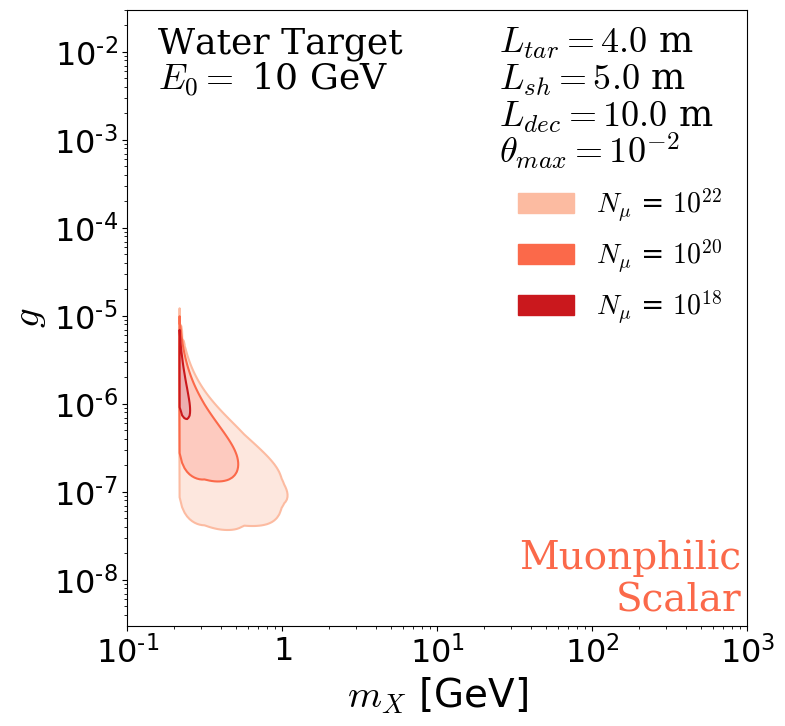

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


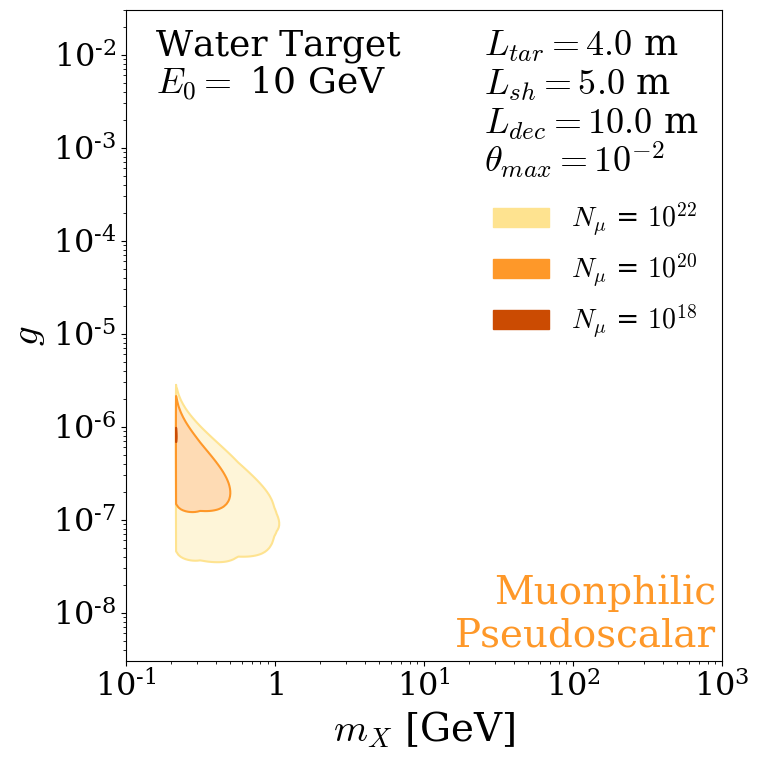

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


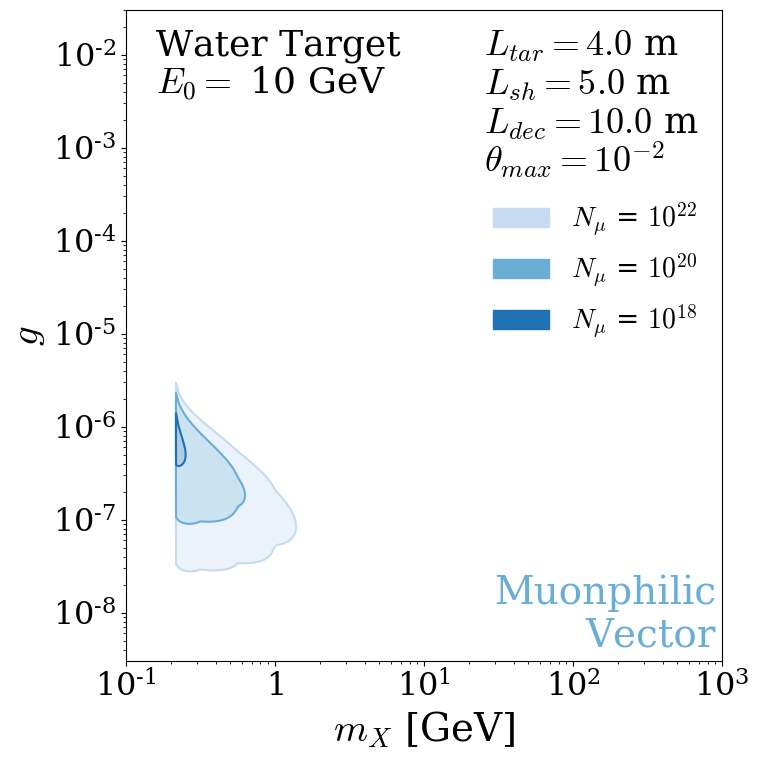

[(0.7792233756247597, 0.9132333717800846, 0.7518031526336024, 1.0), (0.45176470588235296, 0.7670895809304115, 0.4612072279892349, 1.0), (0.1340253748558247, 0.5423298731257208, 0.26828143021914647, 1.0)]


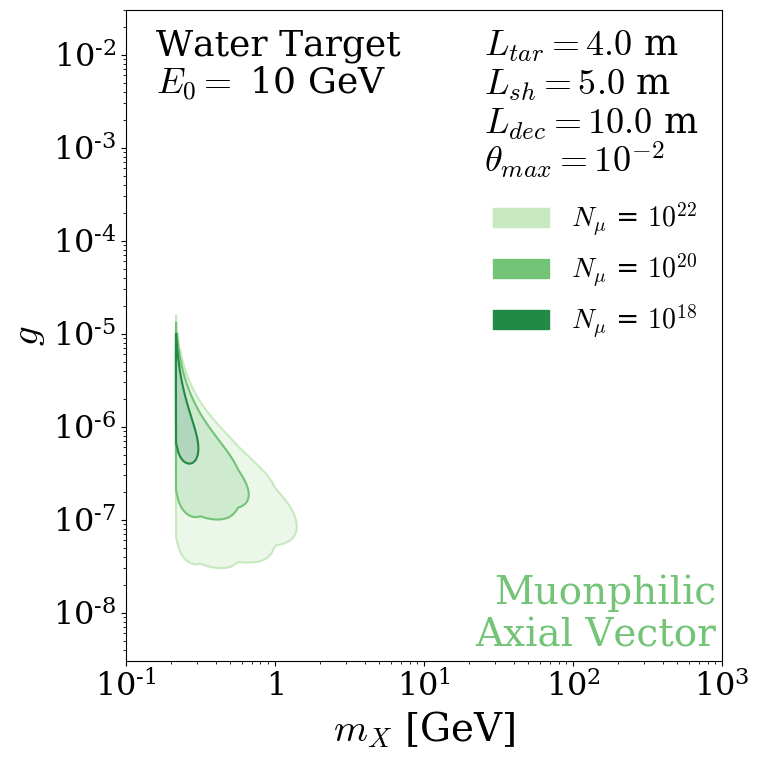

Checking for existing event yield data at experiments/Water/experiment_muonphilic_e63_t10_s10_d50/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 50m, at 63 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


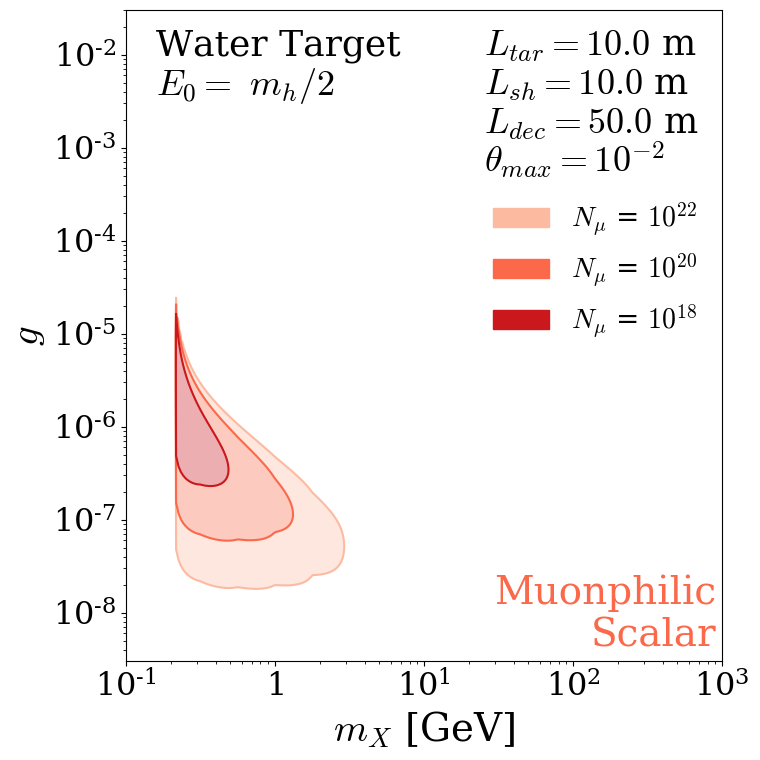

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


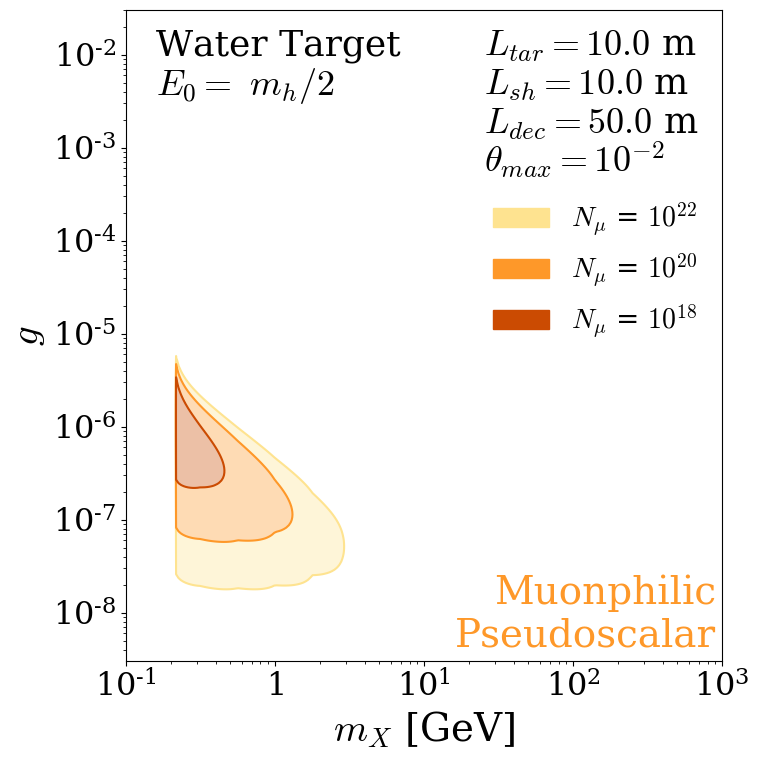

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


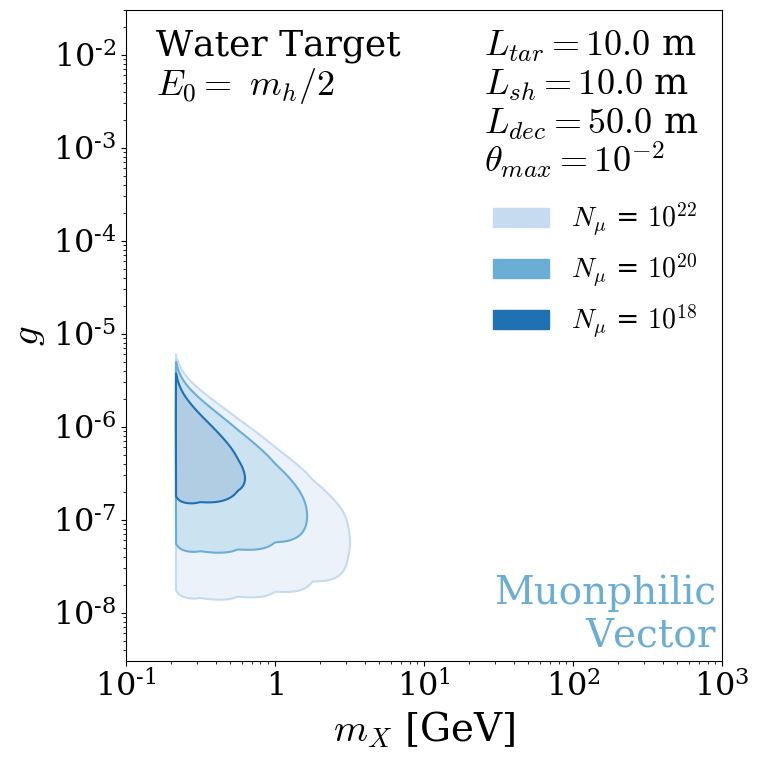

[(0.7792233756247597, 0.9132333717800846, 0.7518031526336024, 1.0), (0.45176470588235296, 0.7670895809304115, 0.4612072279892349, 1.0), (0.1340253748558247, 0.5423298731257208, 0.26828143021914647, 1.0)]


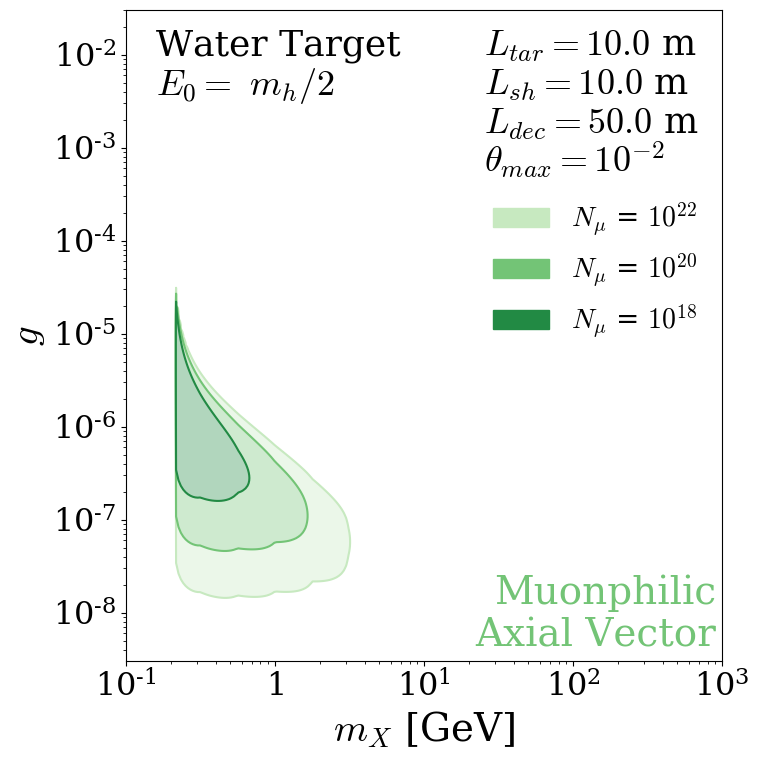

Checking for existing event yield data at experiments/Water/experiment_muonphilic_e1500_t10_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 100m, at 1500 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


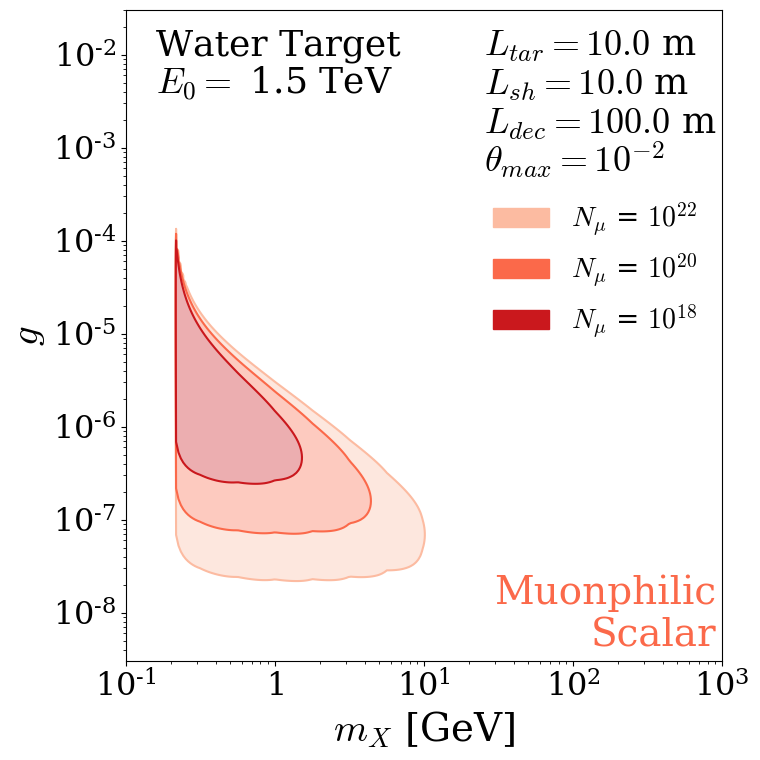

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


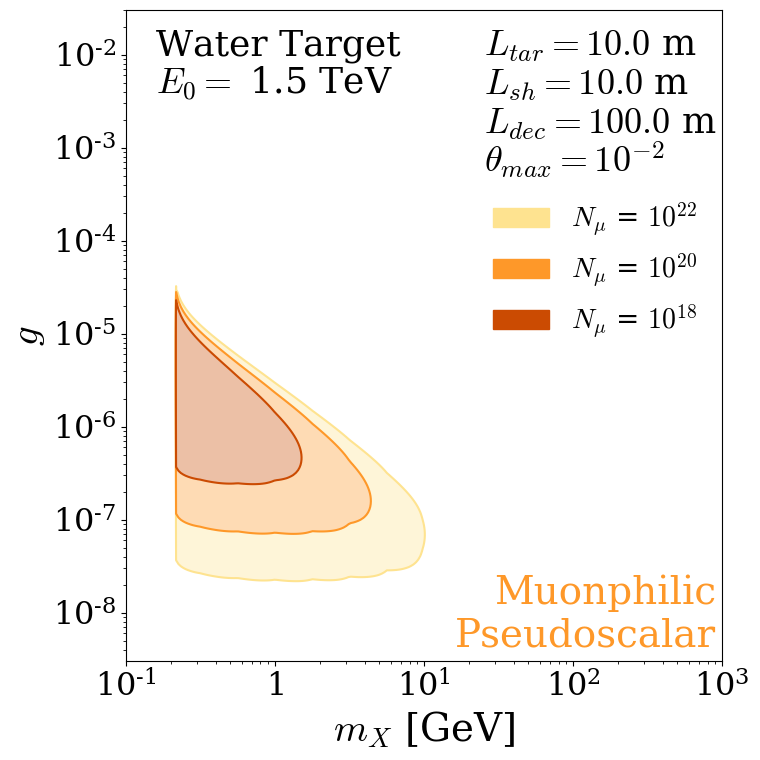

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


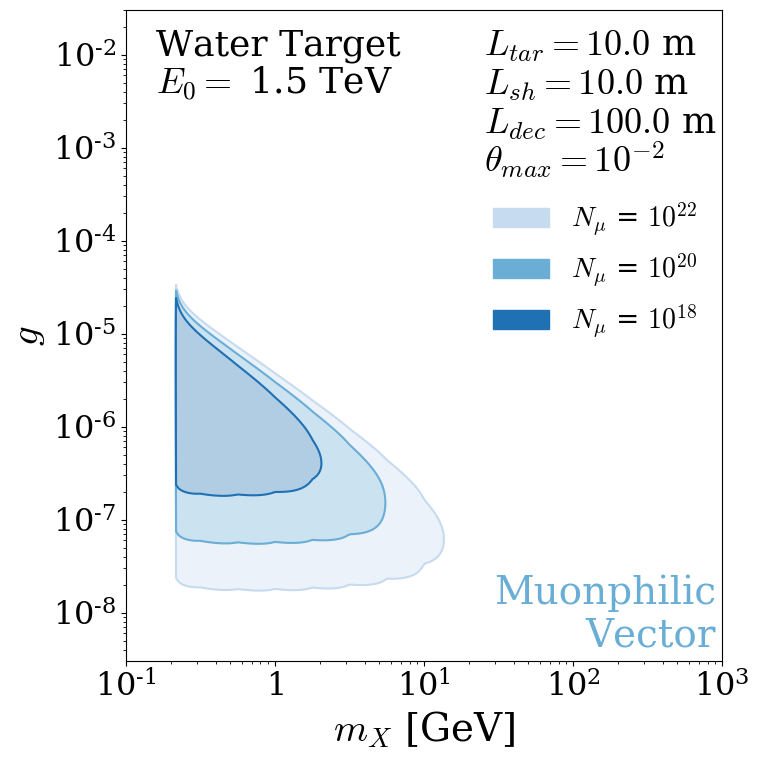

[(0.7792233756247597, 0.9132333717800846, 0.7518031526336024, 1.0), (0.45176470588235296, 0.7670895809304115, 0.4612072279892349, 1.0), (0.1340253748558247, 0.5423298731257208, 0.26828143021914647, 1.0)]


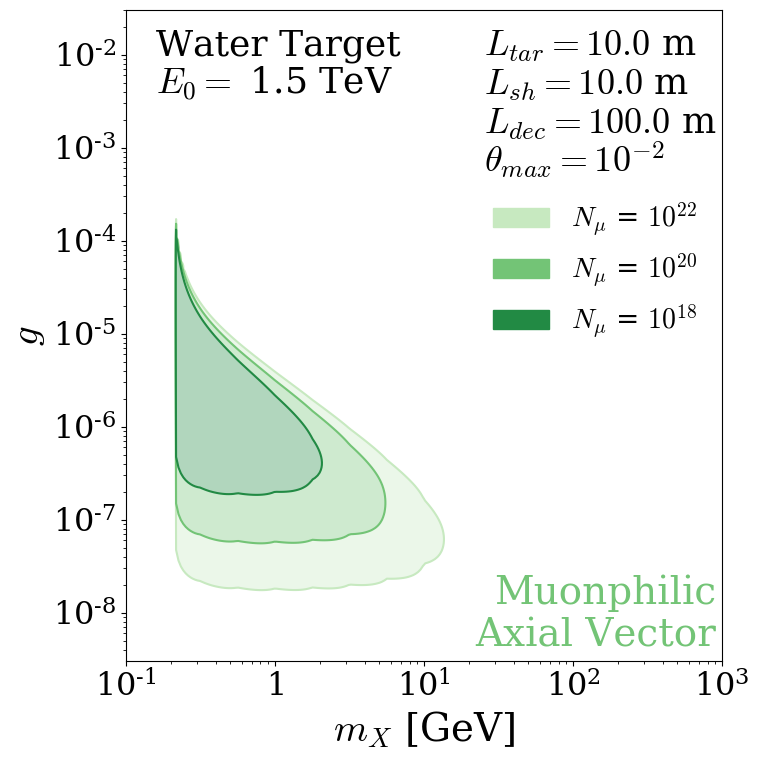

Checking for existing event yield data at experiments/Water/experiment_muonphilic_e5000_t10_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 100m, at 5000 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


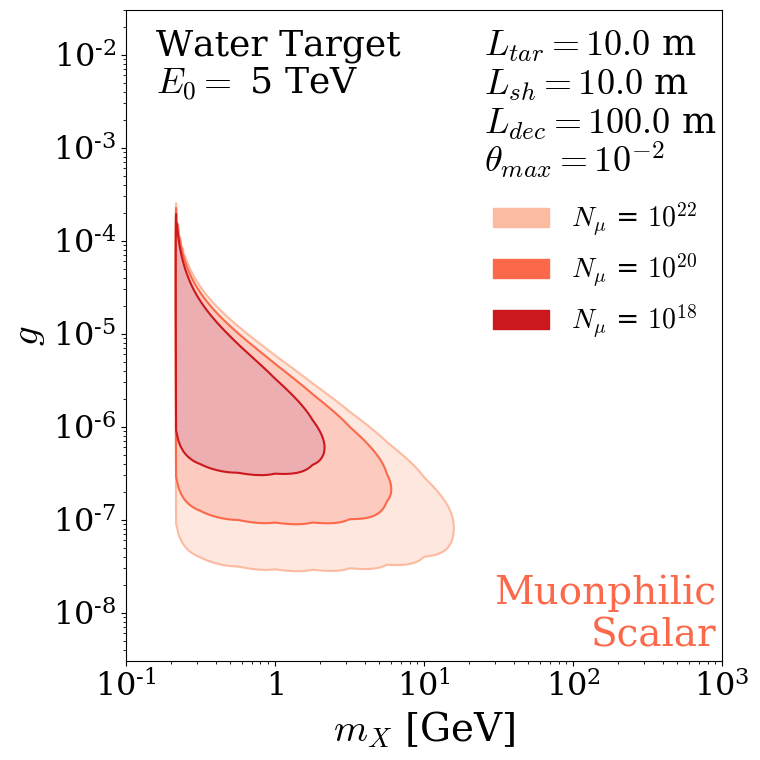

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


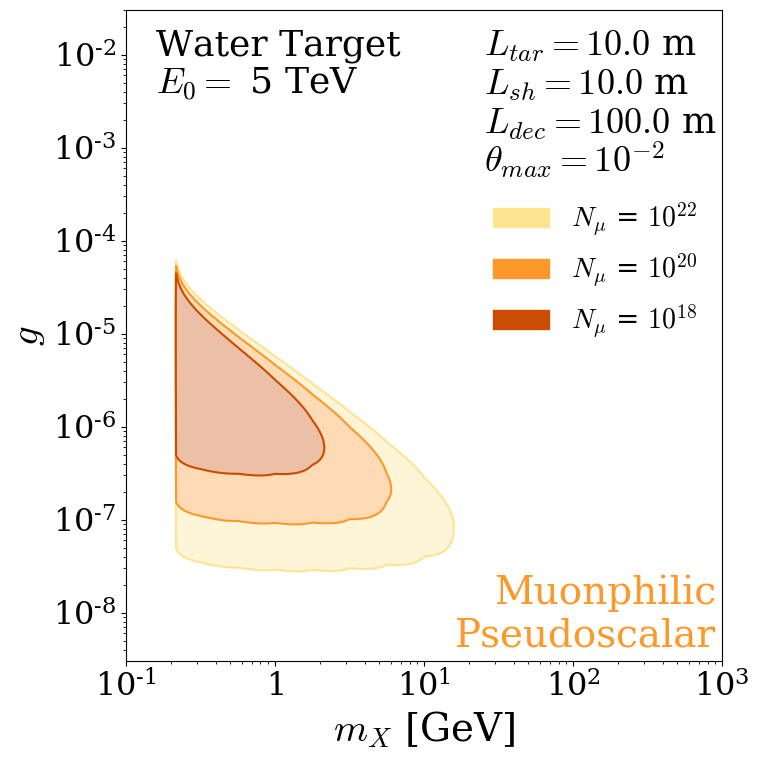

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


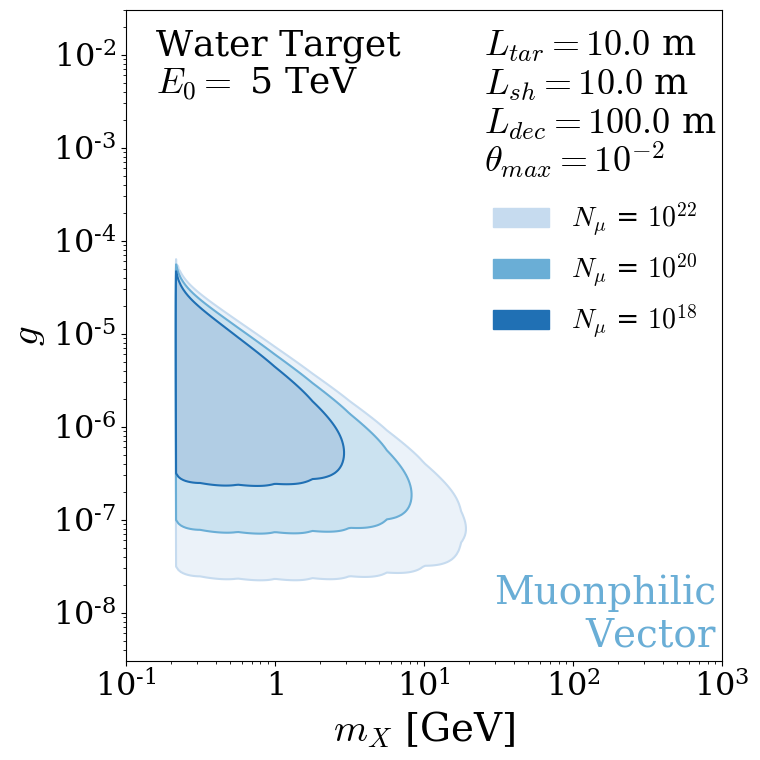

[(0.7792233756247597, 0.9132333717800846, 0.7518031526336024, 1.0), (0.45176470588235296, 0.7670895809304115, 0.4612072279892349, 1.0), (0.1340253748558247, 0.5423298731257208, 0.26828143021914647, 1.0)]


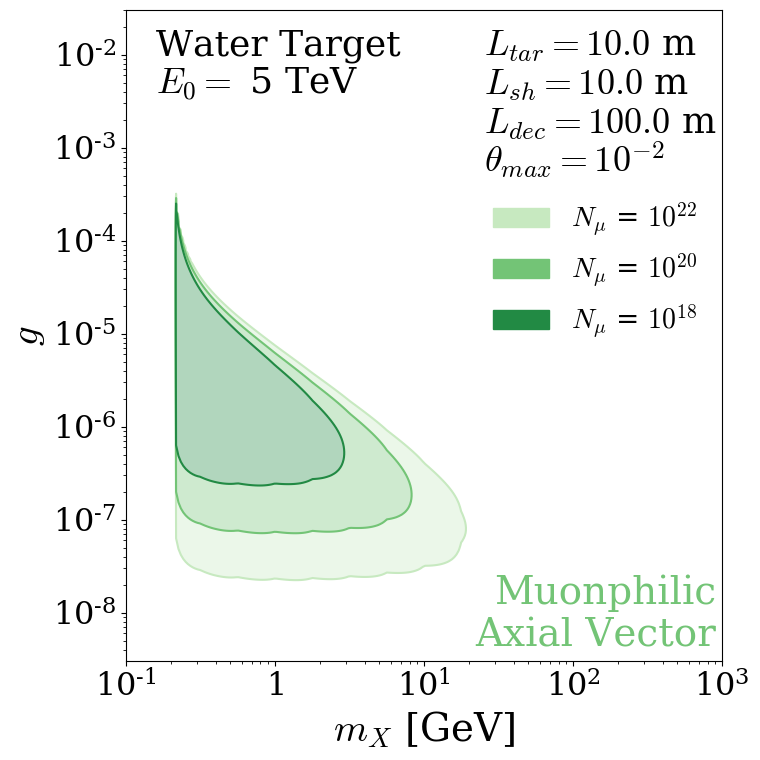

Checking for existing event yield data at experiments/Lead/experiment_muonphilic_e10_t0.5_s5_d10/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 0m, 5m, 10m, at 10 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


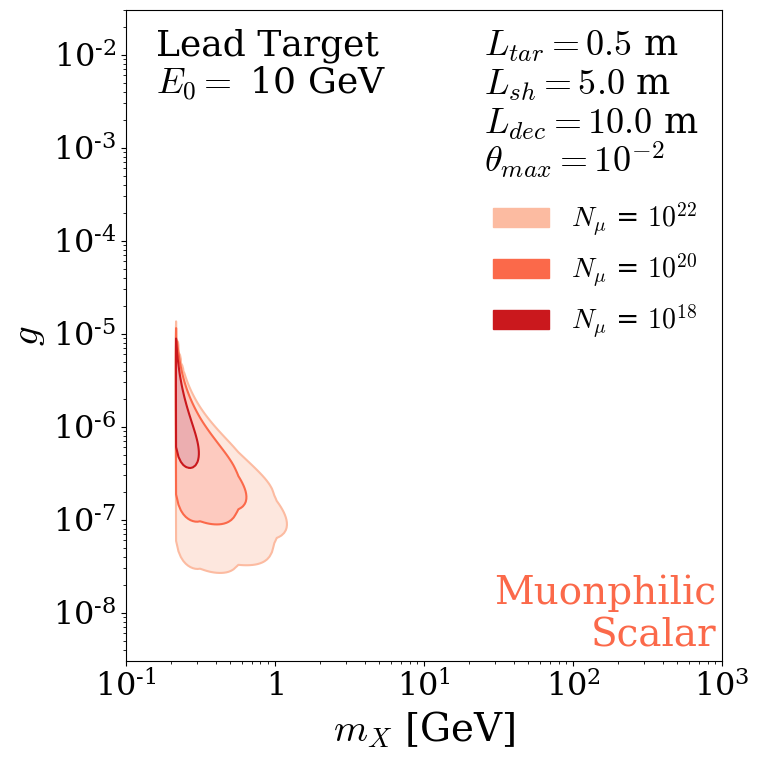

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


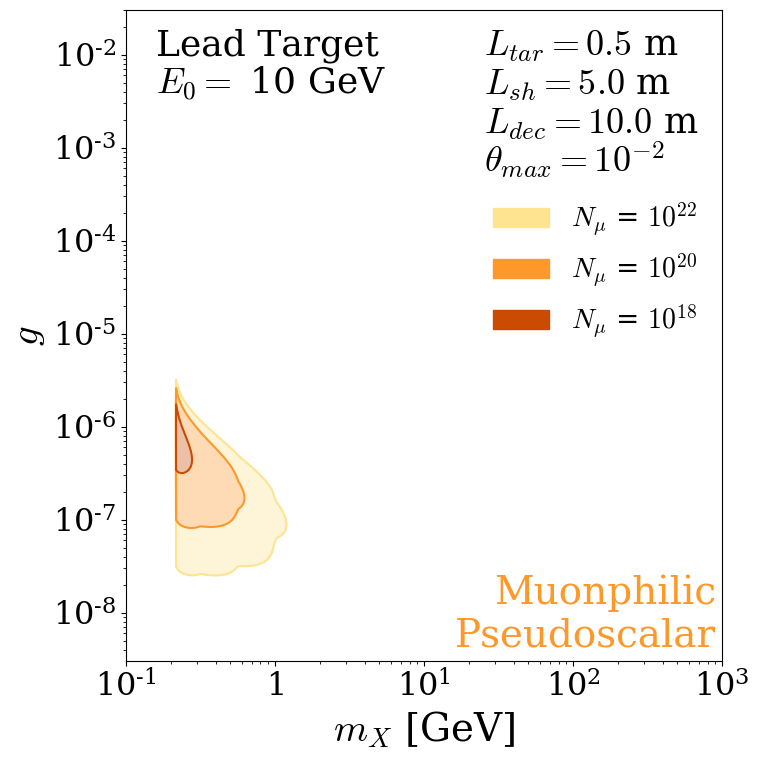

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


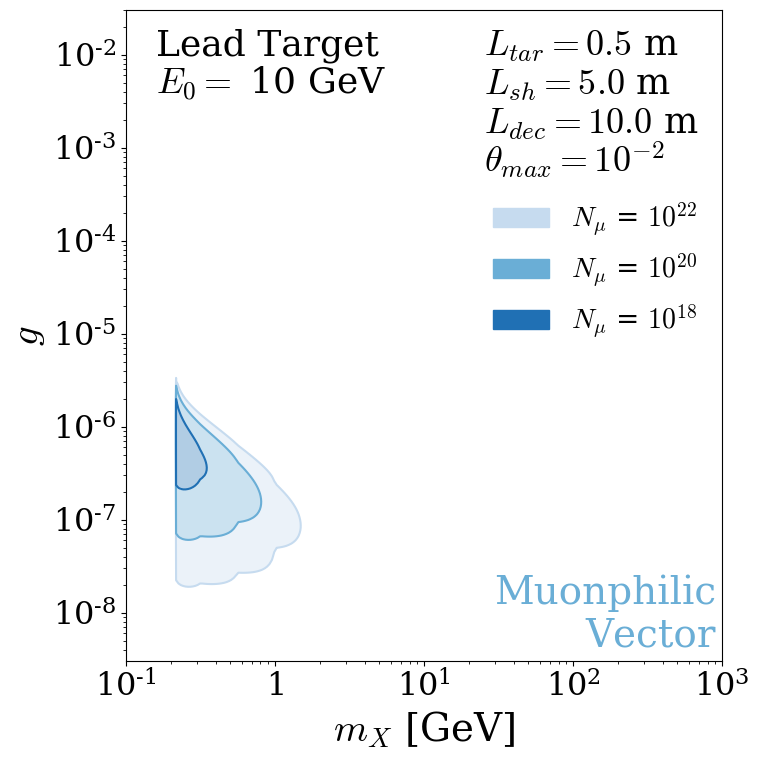

[(0.7792233756247597, 0.9132333717800846, 0.7518031526336024, 1.0), (0.45176470588235296, 0.7670895809304115, 0.4612072279892349, 1.0), (0.1340253748558247, 0.5423298731257208, 0.26828143021914647, 1.0)]


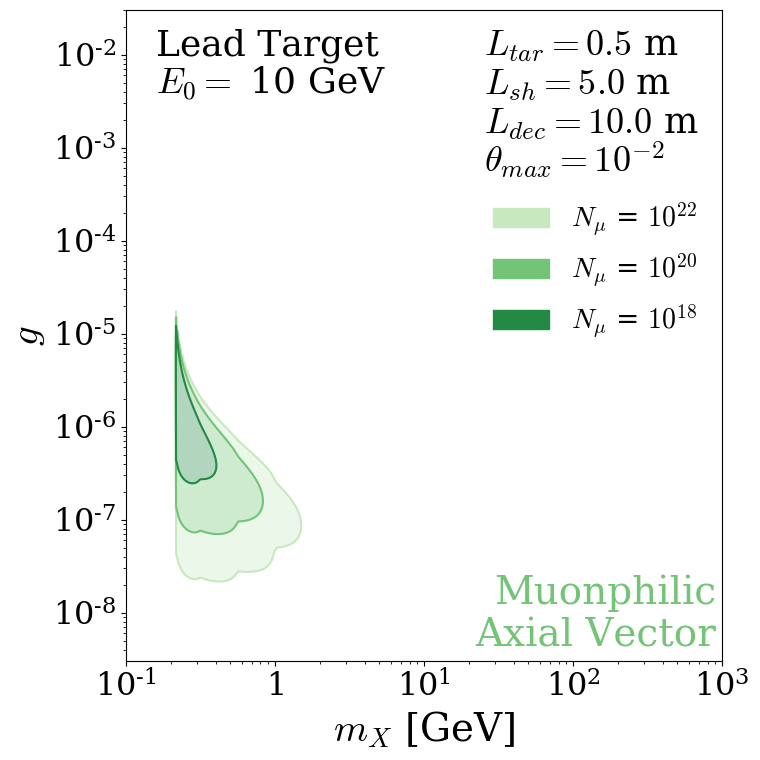

Checking for existing event yield data at experiments/Lead/experiment_muonphilic_e63_t2_s10_d50/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 2m, 10m, 50m, at 63 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


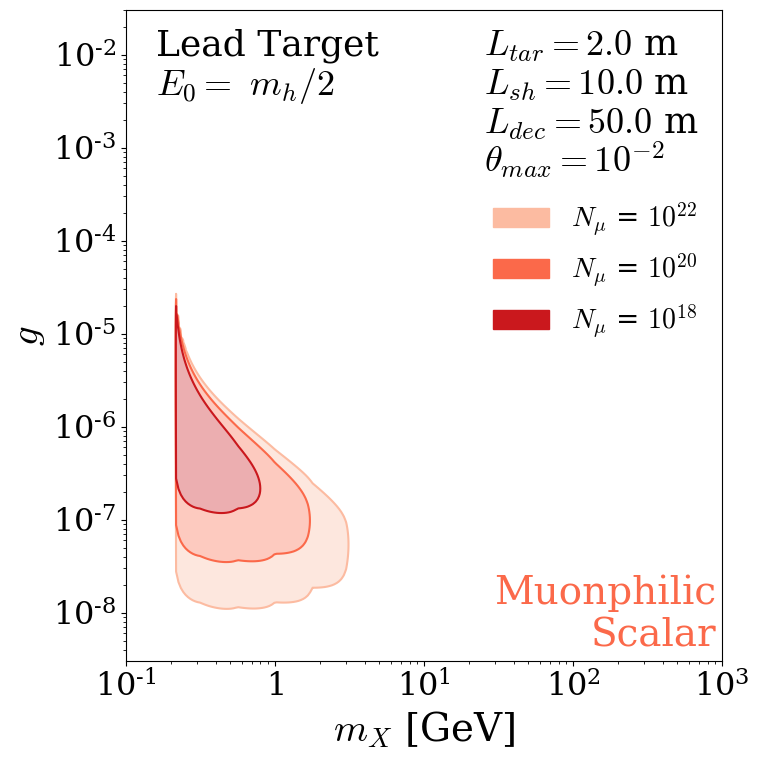

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


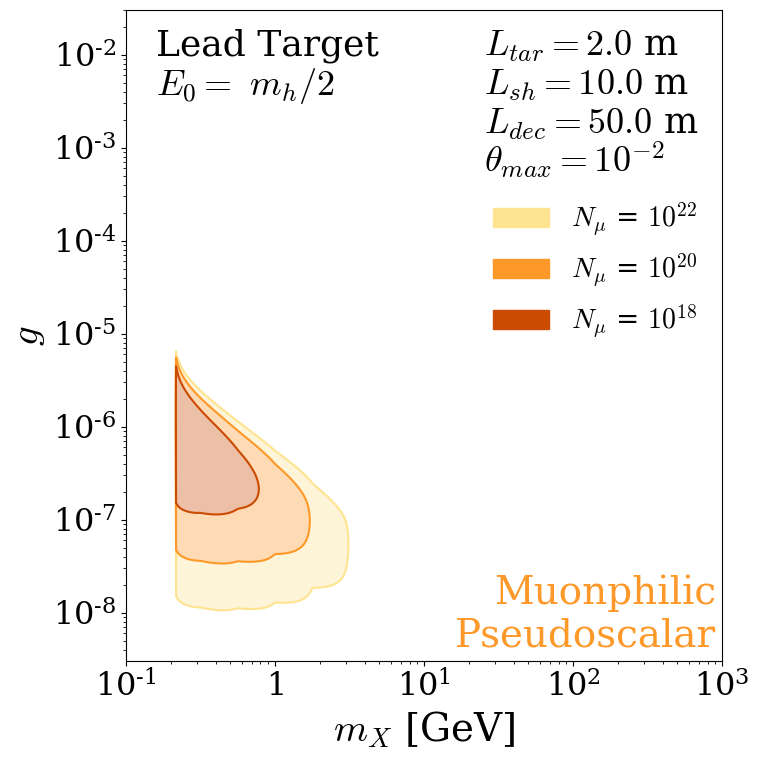

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


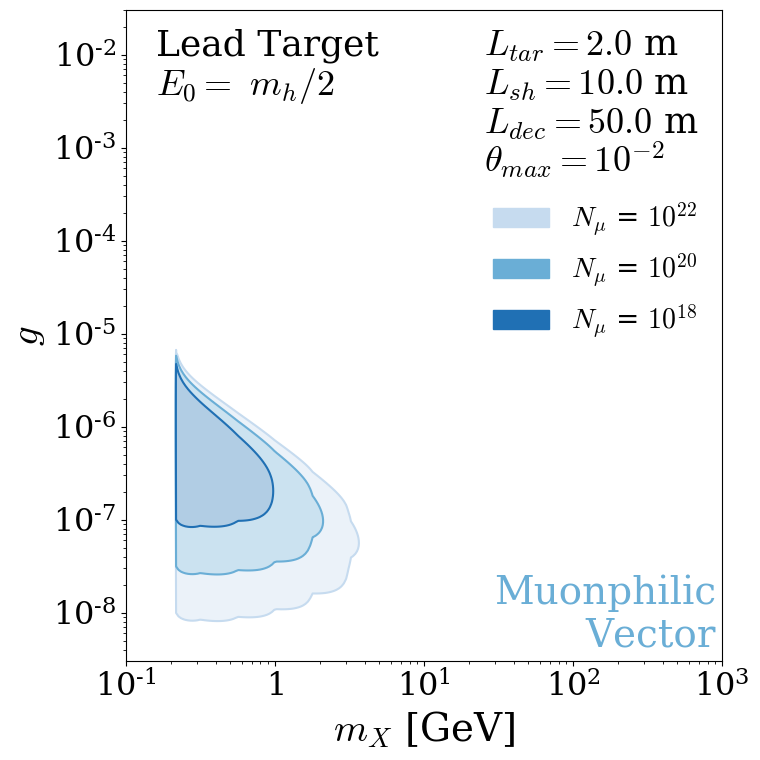

[(0.7792233756247597, 0.9132333717800846, 0.7518031526336024, 1.0), (0.45176470588235296, 0.7670895809304115, 0.4612072279892349, 1.0), (0.1340253748558247, 0.5423298731257208, 0.26828143021914647, 1.0)]


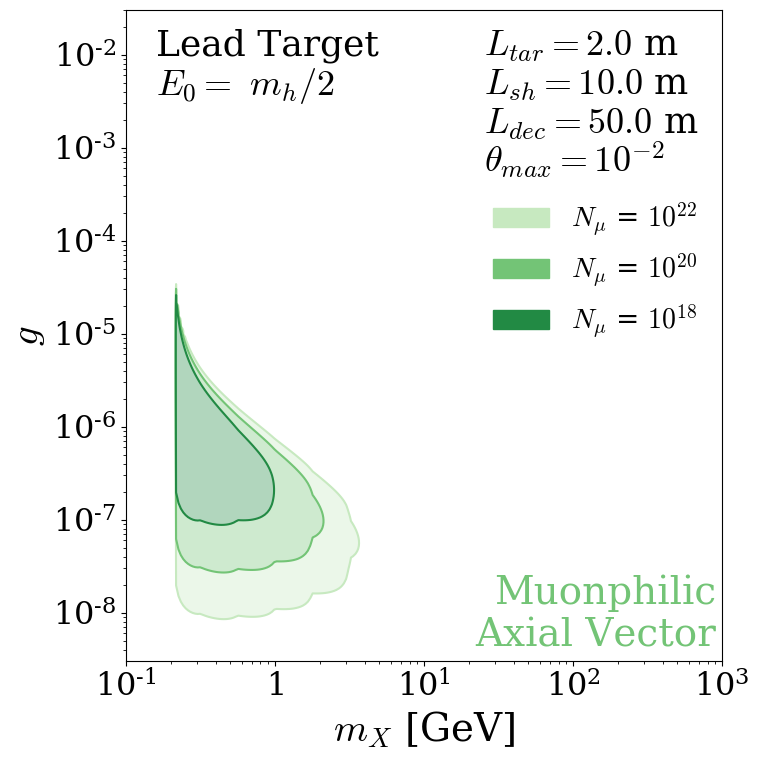

Checking for existing event yield data at experiments/Lead/experiment_muonphilic_e1500_t5_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 5m, 10m, 100m, at 1500 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


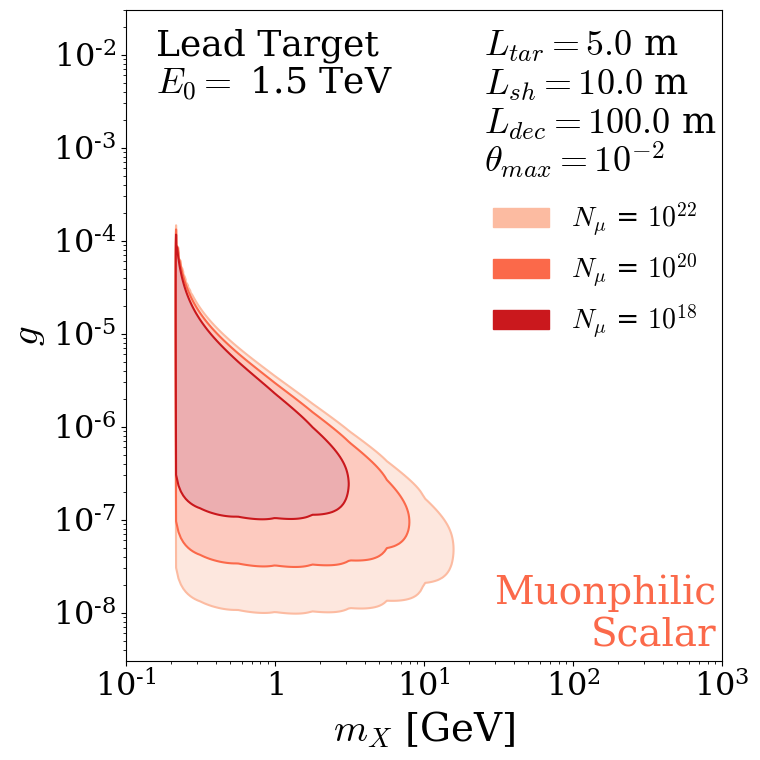

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


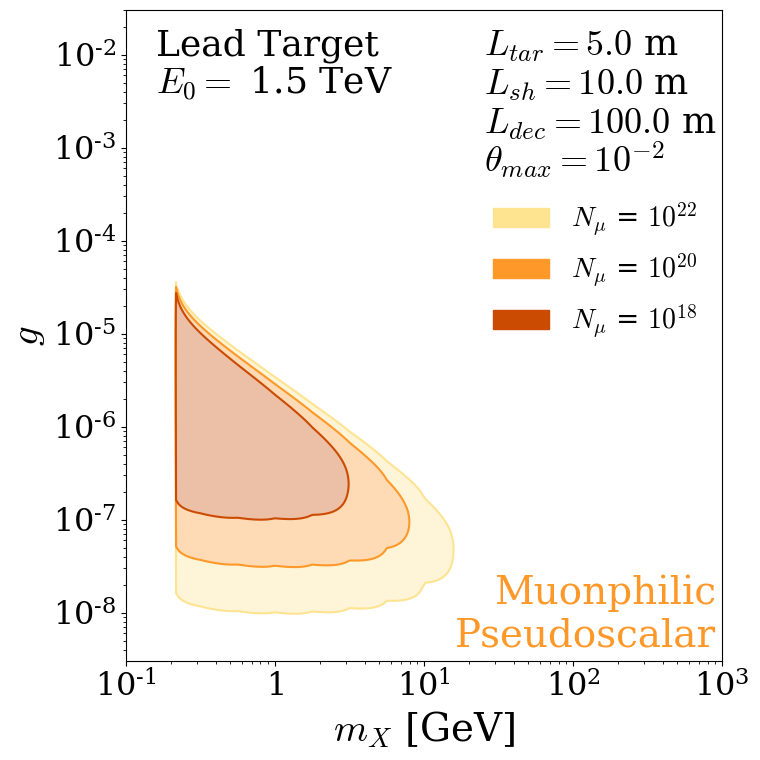

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


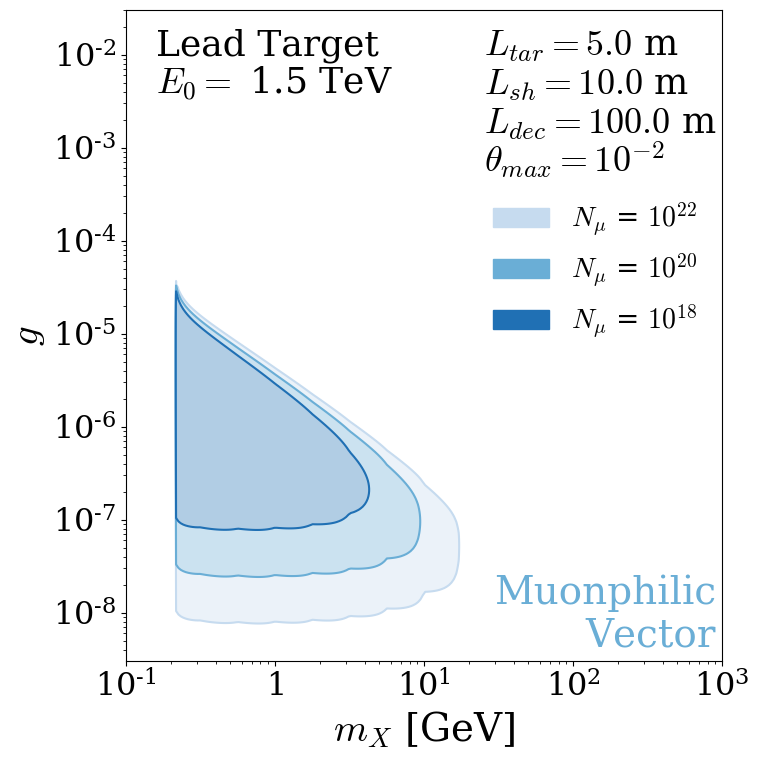

[(0.7792233756247597, 0.9132333717800846, 0.7518031526336024, 1.0), (0.45176470588235296, 0.7670895809304115, 0.4612072279892349, 1.0), (0.1340253748558247, 0.5423298731257208, 0.26828143021914647, 1.0)]


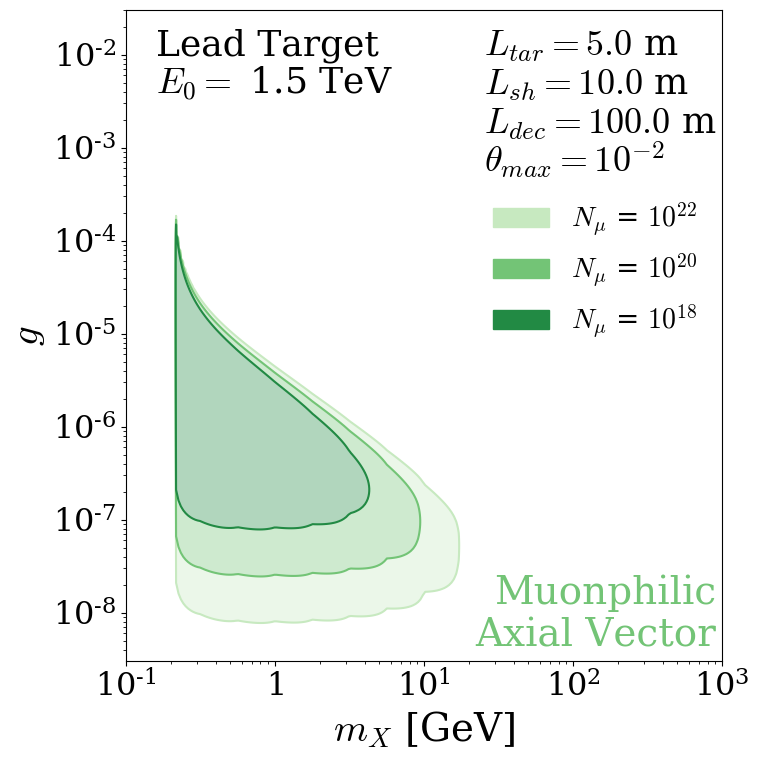

Checking for existing event yield data at experiments/Lead/experiment_muonphilic_e5000_t5_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 5m, 10m, 100m, at 5000 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


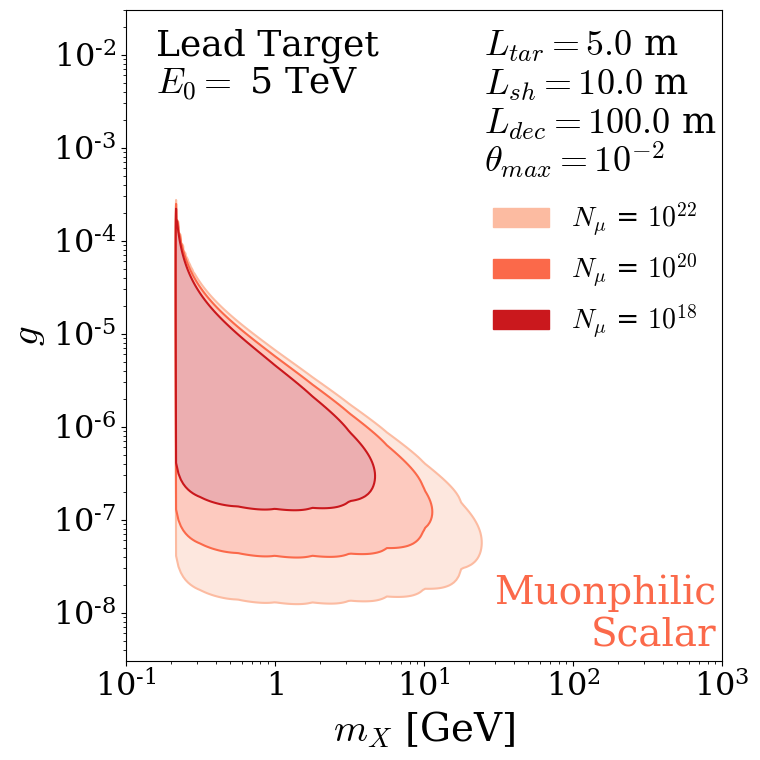

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


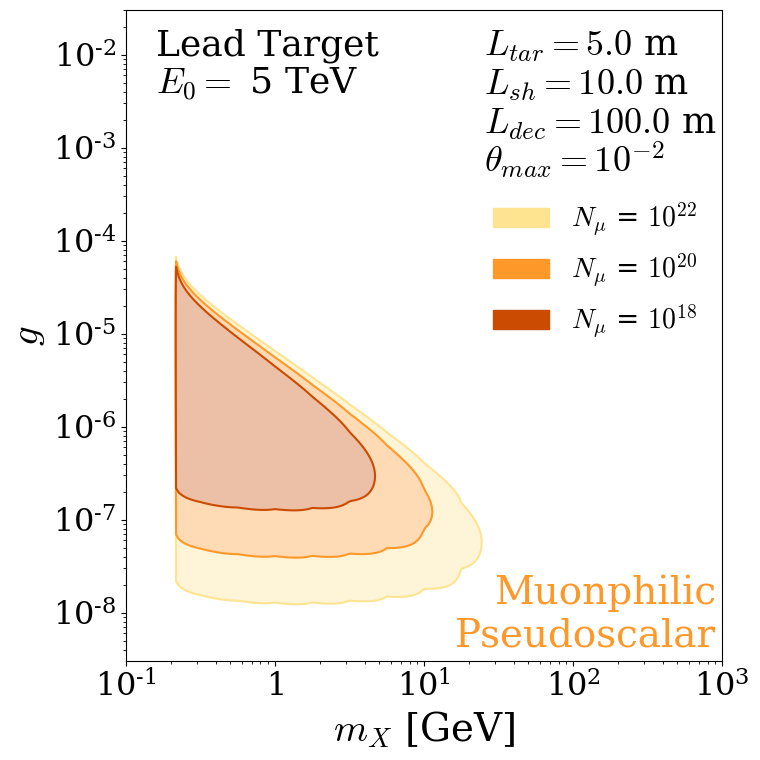

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


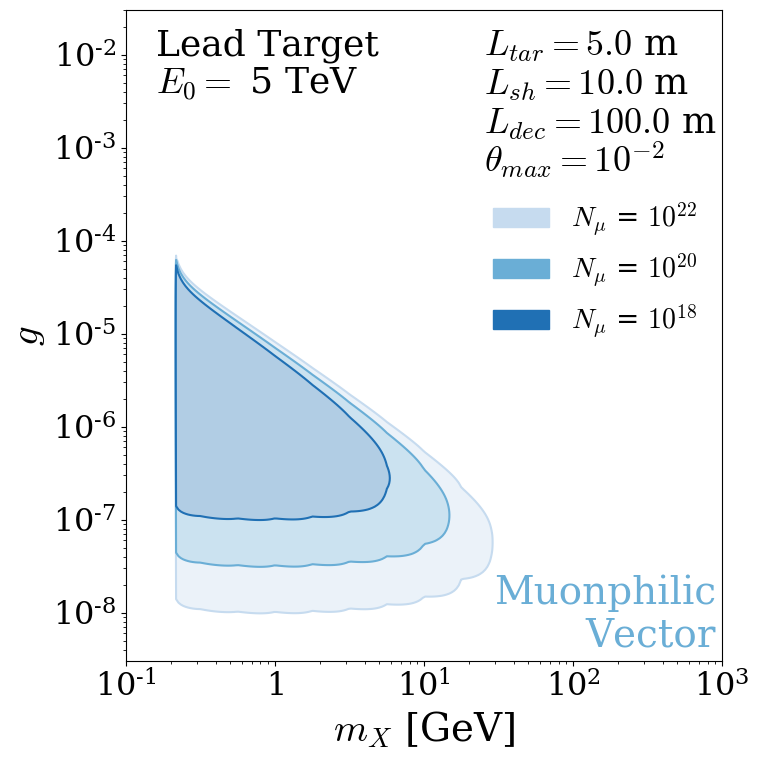

[(0.7792233756247597, 0.9132333717800846, 0.7518031526336024, 1.0), (0.45176470588235296, 0.7670895809304115, 0.4612072279892349, 1.0), (0.1340253748558247, 0.5423298731257208, 0.26828143021914647, 1.0)]


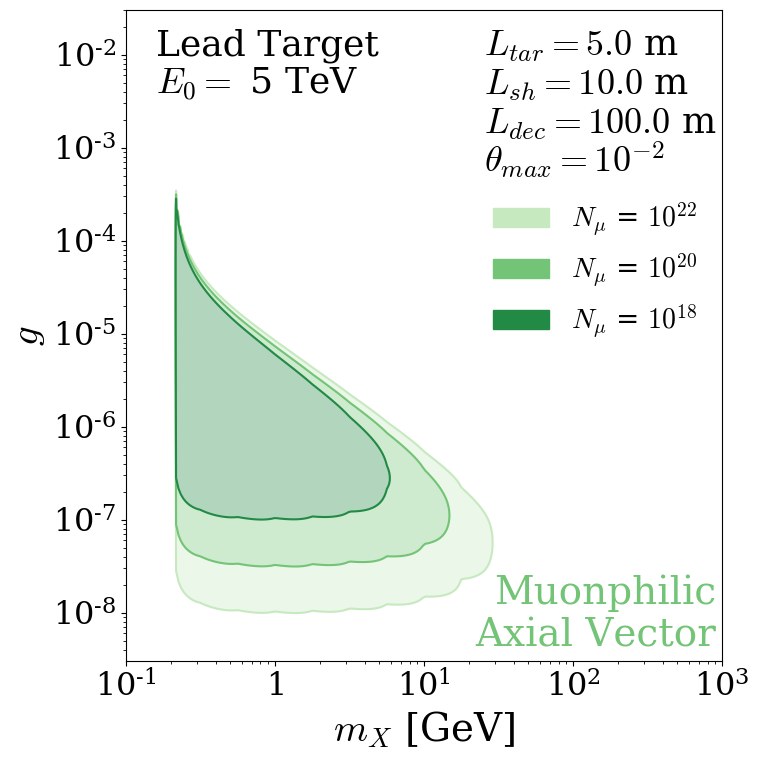

False

In [4]:
# ########## Muonphilic model parameters ##########
plot_mrange = (-1, 3)
plot_erange = (-8, -1)
epsilon_vs_g = False

cases = ["Scalar", "Pseudoscalar", "Vector", "Axial Vector"]

# Decay Parameters
model_names = {"Scalar" : "Muonphilic Scalar", "Pseudoscalar" : "Muonphilic Pseudoscalar", "Vector" : "Muonphilic Vector", "Axial Vector" : "Muonphilic Axial Vector"}
model_name_string = "muonphilic"
decay_dictionary = { # Format is [weight, mass, visibility]
                    "electrons" : [0, 0.000511, 1],
                    "muons" : [1, 0.105, 1],
                    "taus" : [0, 1.776, 0],
                    "neutrinos" : [0, 0, 0],
                    "hadrons" : [0, 0.105, 1], # Weight gets multiplied by Rpp
                    }

# #################################################
# ##### Don't touch below #########################

# Build configs
if run_muonphilic:
    for target in targets:
        for E in E_0s:

            target_name = target
            target_Z = Zs[target]                # Target nucleus's electric charge
            target_A = As[target]             # Target atomic mass [g/mol] ~ [GeV]
            target_density = rhos[target]           # Target material density [g/cm3]
            target_length = l_T[target][E]          # Length of target [m]

            cross_section_dir = f"experiments/{target_name}/cross_sections/"
            experiment_dir = f"experiments/{target_name}/experiment_{model_name_string}_e{E}_t{target_length}_s{shield_lengths[E]}_d{detector_lengths[E]}/"

            config = build_full_config(E < 100, xbins, cases, m_Xs, cross_section_dir, experiment_dir, E, m_lepton, theta_max, target_name, target_Z, target_A, target_density, target_length, shield_lengths[E], detector_lengths[E],  model_name_string, decay_dictionary, N_mu, plot_mrange, plot_erange)        
            calculate_event_yields(config, force_rerun = force_rerun)

            exclusion_plot(config, "Scalar", model_names["Scalar"], [np.log10(5e-2), np.log10(5), np.log10(5e2)], "Reds",
                            labels = [r"$ 10^{22}$", r"$ 10^{20}$", r"$ 10^{18}$"], epsilon_vs_g = epsilon_vs_g)
            exclusion_plot(config, "Pseudoscalar", model_names["Pseudoscalar"], [np.log10(5e-2), np.log10(5), np.log10(5e2)], "YlOrBr",
                            labels = [r"$ 10^{22}$", r"$ 10^{20}$", r"$ 10^{18}$"], epsilon_vs_g = epsilon_vs_g)
            exclusion_plot(config, "Vector", model_names["Vector"], [np.log10(5e-2), np.log10(5), np.log10(5e2)], "Blues",
                            labels = [r"$ 10^{22}$", r"$ 10^{20}$", r"$ 10^{18}$"], epsilon_vs_g = epsilon_vs_g)
            exclusion_plot(config, "Axial Vector", model_names["Axial Vector"], [np.log10(5e-2), np.log10(5), np.log10(5e2)], "Greens",
                            labels = [r"$ 10^{22}$", r"$ 10^{20}$", r"$ 10^{18}$"], epsilon_vs_g = epsilon_vs_g)

False

# $L_\mu - L_\tau$

Checking for existing event yield data at experiments/Water/experiment_lmu_minus_ltau_e10_t4_s5_d10/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 4m, 5m, 10m, at 10 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


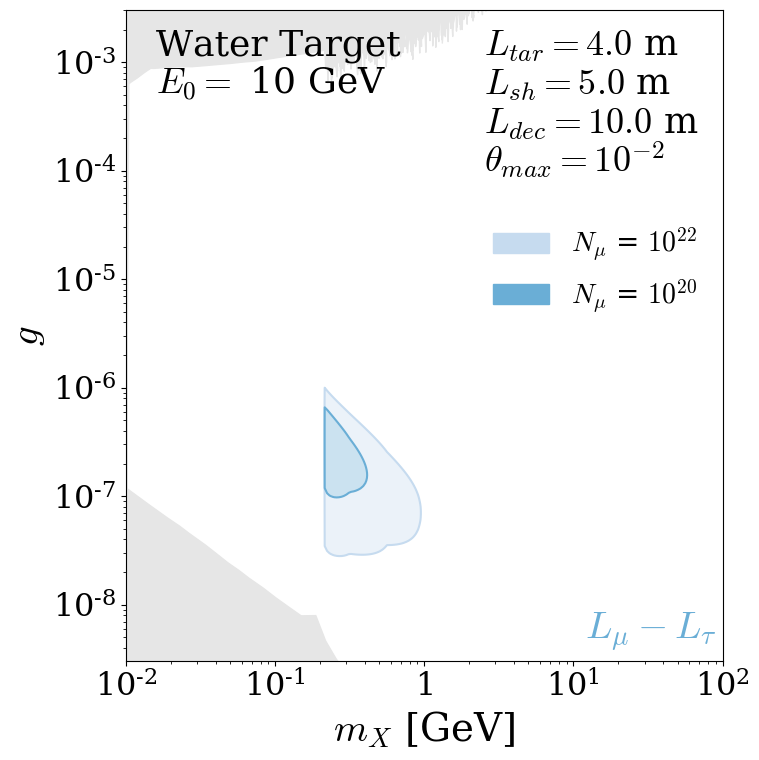

Checking for existing event yield data at experiments/Water/experiment_lmu_minus_ltau_e63_t10_s10_d50/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 50m, at 63 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


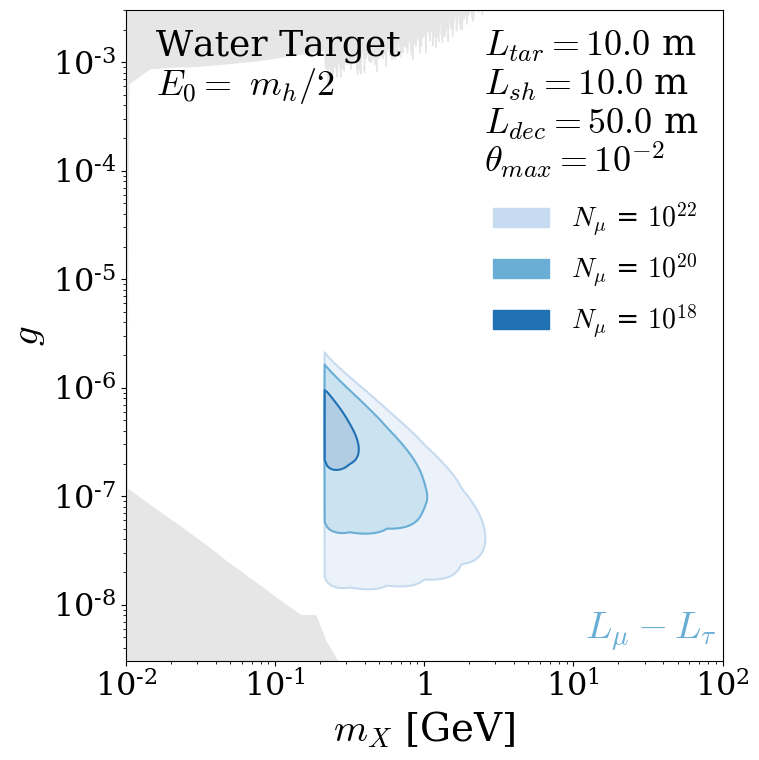

Checking for existing event yield data at experiments/Water/experiment_lmu_minus_ltau_e1500_t10_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 100m, at 1500 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


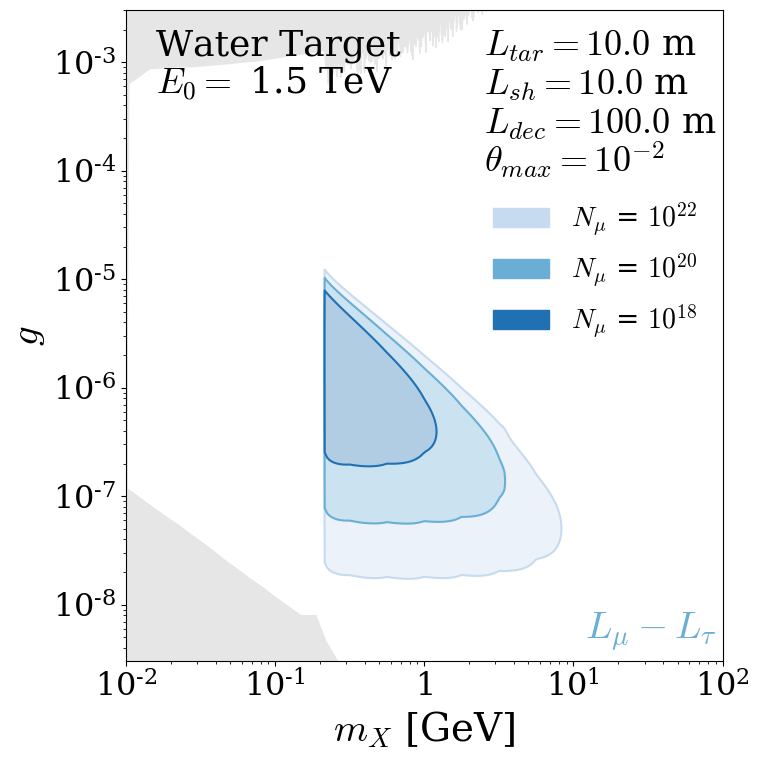

Checking for existing event yield data at experiments/Water/experiment_lmu_minus_ltau_e5000_t10_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 100m, at 5000 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


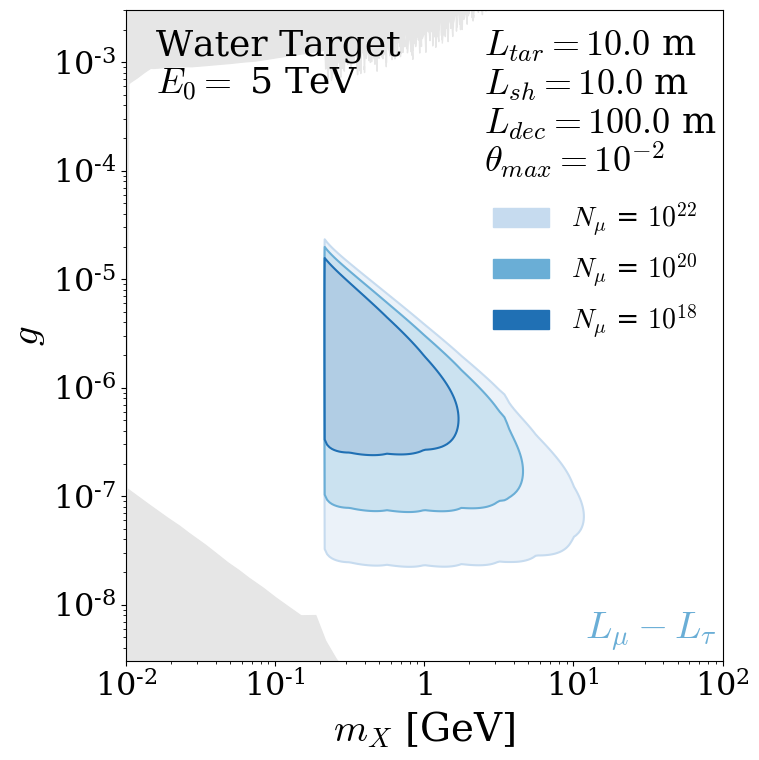

Checking for existing event yield data at experiments/Lead/experiment_lmu_minus_ltau_e10_t0.5_s5_d10/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 0m, 5m, 10m, at 10 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


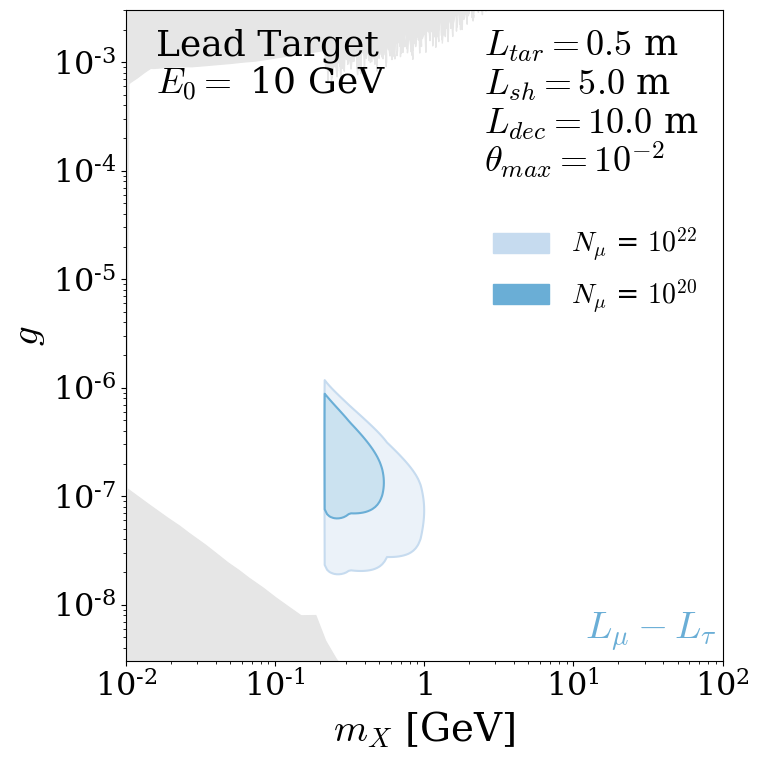

Checking for existing event yield data at experiments/Lead/experiment_lmu_minus_ltau_e63_t2_s10_d50/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 2m, 10m, 50m, at 63 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


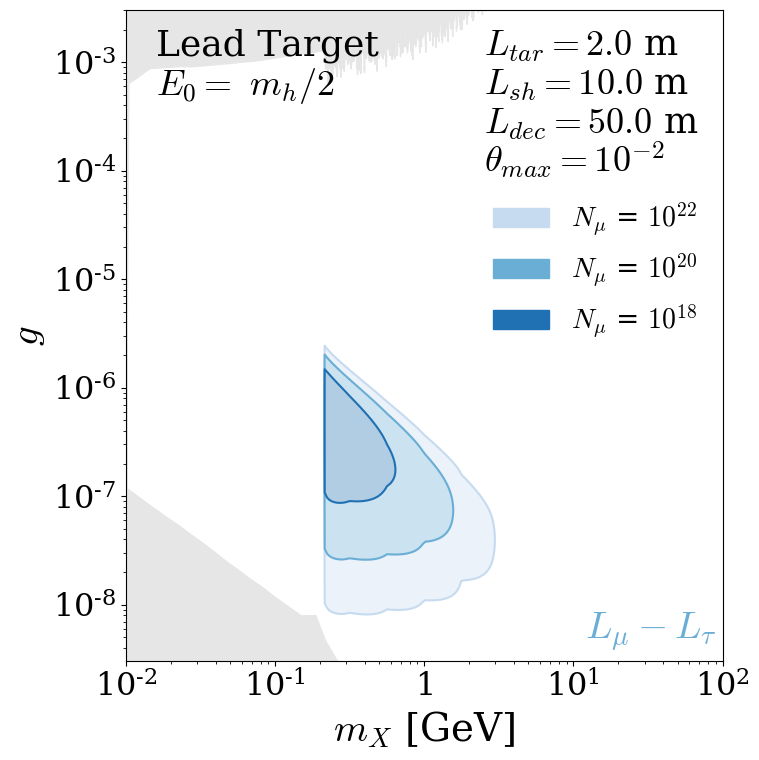

Checking for existing event yield data at experiments/Lead/experiment_lmu_minus_ltau_e1500_t5_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 5m, 10m, 100m, at 1500 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


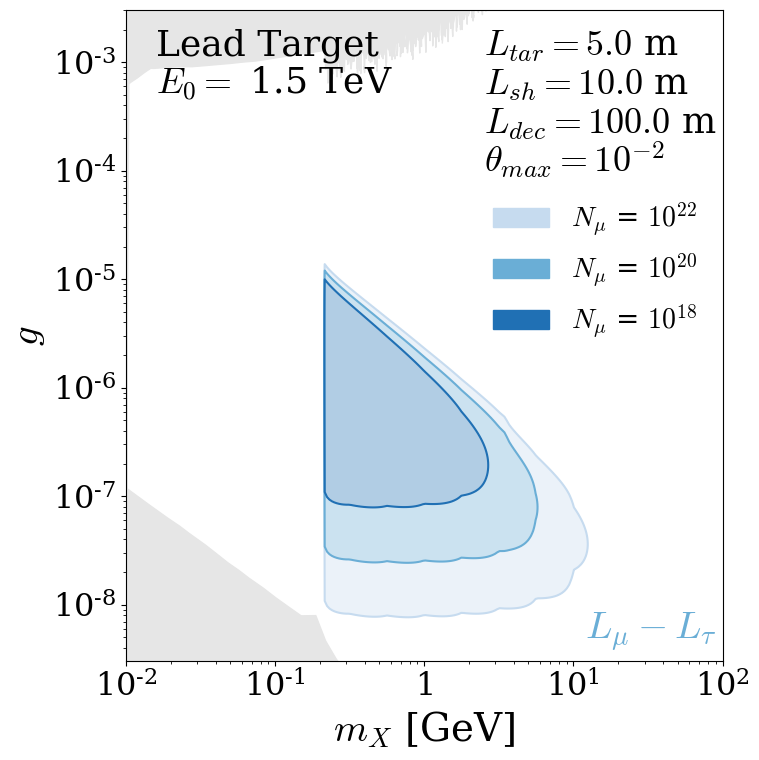

Checking for existing event yield data at experiments/Lead/experiment_lmu_minus_ltau_e5000_t5_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 5m, 10m, 100m, at 5000 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


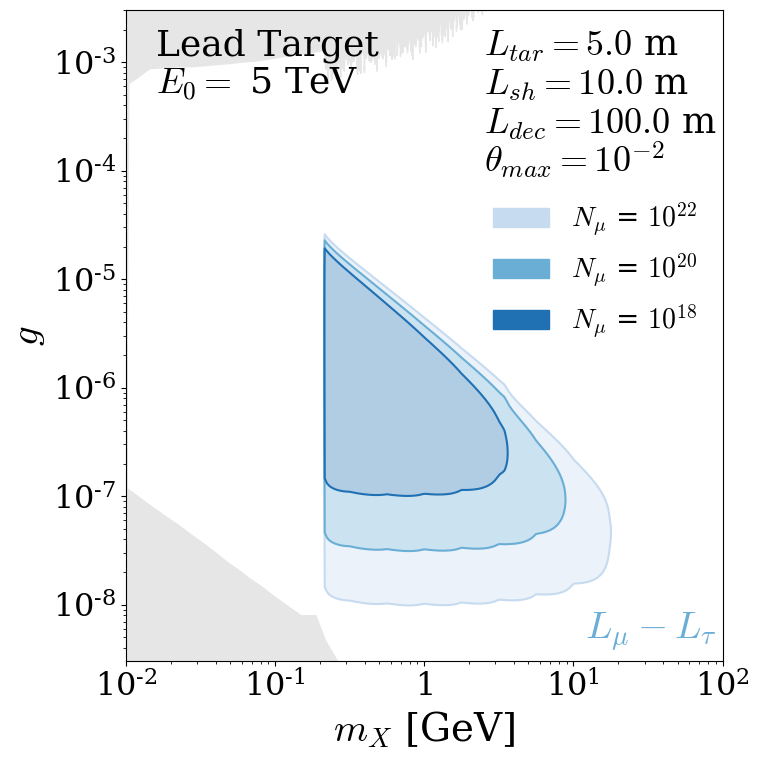

In [5]:
# ########## Lmu-Ltau model parameters ##########
plot_mrange = (-2, 2)
plot_erange = (-8, -2)
epsilon_vs_g = False

cases = ["Vector"]

# Decay Parameters
model_names = {"Vector" : r"$L_\mu-L_\tau$",}
model_name_string = "lmu_minus_ltau"
decay_dictionary = { # Format is [weight, mass, visibility]
                    "electrons" : [0, 0.000511, 1],
                    "muons" : [1, 0.105, 1],
                    "taus" : [1, 1.776, 0],
                    "neutrinos" : [2, 0, 0],
                    "hadrons" : [0, 0.105, 1], # Weight gets multiplied by Rpp
                    }


# ##### Load data #####

# Searches
lmu_minus_ltau_digitized_dir = "OtherSearchesDigitized/digitized-bounds/lmu-ltau/"

babar_data = read_digitized(lmu_minus_ltau_digitized_dir + "babar-lmu-lta-limit.csv", None, None, firstrow=00)
borexino_data = read_digitized(lmu_minus_ltau_digitized_dir + "borexino-limit.csv", None, None, firstrow=00)
ccfr_1_data = read_digitized(lmu_minus_ltau_digitized_dir + "ccfr-limit.csv", None, None, firstrow=00)
sn1987_data_1 = read_digitized(lmu_minus_ltau_digitized_dir + "sn1987-limit-1.csv", None, None, firstrow=00)
sn1987_data_2 = read_digitized(lmu_minus_ltau_digitized_dir + "sn1987-limit-2.csv", None, None, firstrow=00)
bbn_data = read_digitized(lmu_minus_ltau_digitized_dir + "Neff0p5-line.csv", None, None, firstrow=00)

searches = [babar_data, borexino_data, ccfr_1_data,bbn_data]



# #################################################
# ##### Don't touch below #########################

# Build configs
if run_lmu_minus_ltau:
    for target in targets:
        for E in E_0s:

            target_name = target
            target_Z = Zs[target]                # Target nucleus's electric charge
            target_A = As[target]             # Target atomic mass [g/mol] ~ [GeV]
            target_density = rhos[target]           # Target material density [g/cm3]
            target_length = l_T[target][E]          # Length of target [m]

            cross_section_dir = f"experiments/{target_name}/cross_sections/"
            experiment_dir = f"experiments/{target_name}/experiment_{model_name_string}_e{E}_t{target_length}_s{shield_lengths[E]}_d{detector_lengths[E]}/"

            config = build_full_config(E < 100, xbins, cases, m_Xs, cross_section_dir, experiment_dir, E, m_lepton, theta_max, target_name, target_Z, target_A, target_density, target_length, shield_lengths[E], detector_lengths[E],  model_name_string, decay_dictionary, N_mu, plot_mrange, plot_erange)        
            calculate_event_yields(config, force_rerun = force_rerun)

            # Plot (Once with dashed lines, once without to coverup scars)
            fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))
            for search in searches:
                plot_grey(ax, config, search, dashed = False)

            ax.fill_between(sn1987_data_1[:,0], sn1987_data_1[:,1], np.interp(sn1987_data_1[:,0], sn1987_data_2[:,0], sn1987_data_2[:,1]), color = (0.9, 0.9, 0.9), zorder = 1)

            # Dashed lines for contours
            merge_and_outline_objects(ax)
            
            exclusion_plot(config, "Vector", model_names["Vector"], [np.log10(5e-2), np.log10(5), np.log10(5e2)], "Blues",
                            labels = [r"$ 10^{22}$", r"$ 10^{20}$", r"$ 10^{18}$"], epsilon_vs_g = epsilon_vs_g,
                            newfig= False)
        

# Leptophilic (OLD)


In [6]:
# # ########## Leptophilic model parameters ##########
# plot_mrange = (-2.5, 2)
# plot_erange = (-9, -2)
# epsilon_vs_g = False

# cases = ["Vector"]

# # Decay Parameters
# model_names = {"Vector" : r"Leptophilic",}
# model_name_string = "leptophilic"
# decay_dictionary = { # Format is [weight, mass, visibility]
#                     "electrons" : [1, 0.000511, 1],
#                     "muons" : [1, 0.105, 1],
#                     "taus" : [1, 1.776, 1],
#                     "neutrinos" : [3, 0, 0],
#                     "hadrons" : [0, 0.105, 1], # Weight gets multiplied by Rpp
#                     }


# dark_photon_digitized_dir = "OtherSearchesDigitized/digitized-bounds/dark-photon/"
# e137old_data = read_digitized(dark_photon_digitized_dir + "e137-dark-photon-bounds.csv", None, None, firstrow=00)
# e137_data = read_digitized(dark_photon_digitized_dir + "e137-updated-dark-photon-bounds.csv", MeV_to_GeV, None, firstrow=00)
# resonances = [e137_data, e137old_data]

# # #################################################
# # ##### Don't touch below #########################

# # Build configs
# if run_leptophilic:
#     for target in targets:
#         for E in E_0s:

#             target_name = target
#             target_Z = Zs[target]                # Target nucleus's electric charge
#             target_A = As[target]             # Target atomic mass [g/mol] ~ [GeV]
#             target_density = rhos[target]           # Target material density [g/cm3]
#             target_length = l_T[target][E]          # Length of target [m]

#             cross_section_dir = f"experiments/{target_name}/cross_sections/"
#             experiment_dir = f"experiments/{target_name}/experiment_{model_name_string}_e{E}_t{target_length}_s{shield_lengths[E]}_d{detector_lengths[E]}/"

#             config = build_full_config(E < 100, xbins, cases, m_Xs, cross_section_dir, experiment_dir, E, m_lepton, theta_max, target_name, target_Z, target_A, target_density, target_length, shield_lengths[E], detector_lengths[E],  model_name_string, decay_dictionary, N_mu, plot_mrange, plot_erange)        
#             calculate_event_yields(config, force_rerun = force_rerun)

#             # Plot
#             fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))
#             for resonance in resonances:
#                 plot_grey(ax, config, resonance)

            
#             exclusion_plot(config, "Vector", model_names["Vector"], [np.log10(5e-2), np.log10(5), np.log10(5e2)], "Blues",
#                             labels = [r"$ 10^{22}$", r"$ 10^{20}$", r"$ 10^{18}$"], epsilon_vs_g = epsilon_vs_g,
#                             newfig=False)
        

# Dark Photon

Checking for existing event yield data at experiments/Water/experiment_darkX_e10_t4_s5_d10/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 4m, 5m, 10m, at 10 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


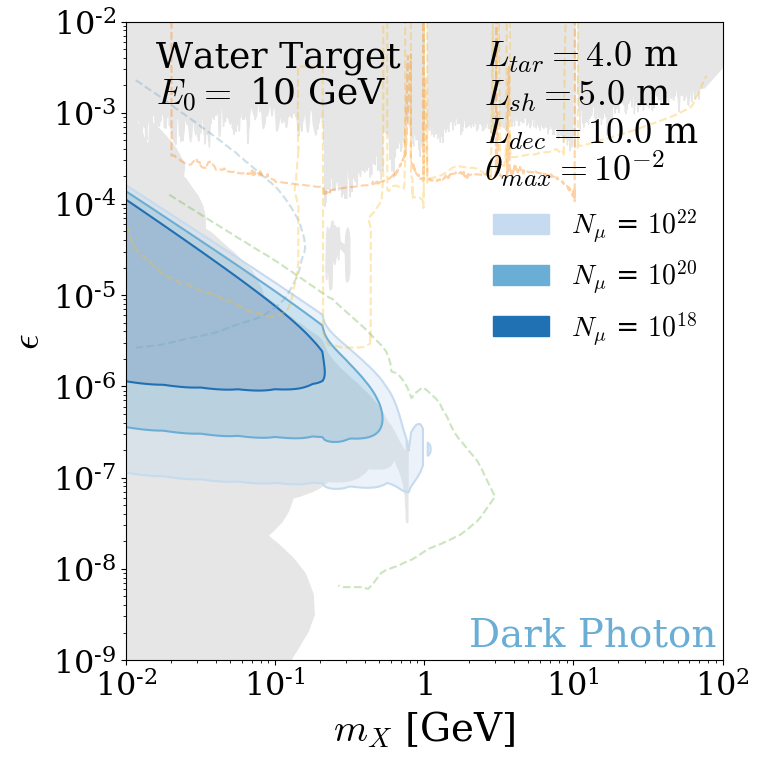

Checking for existing event yield data at experiments/Water/experiment_darkX_e63_t10_s10_d50/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 50m, at 63 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


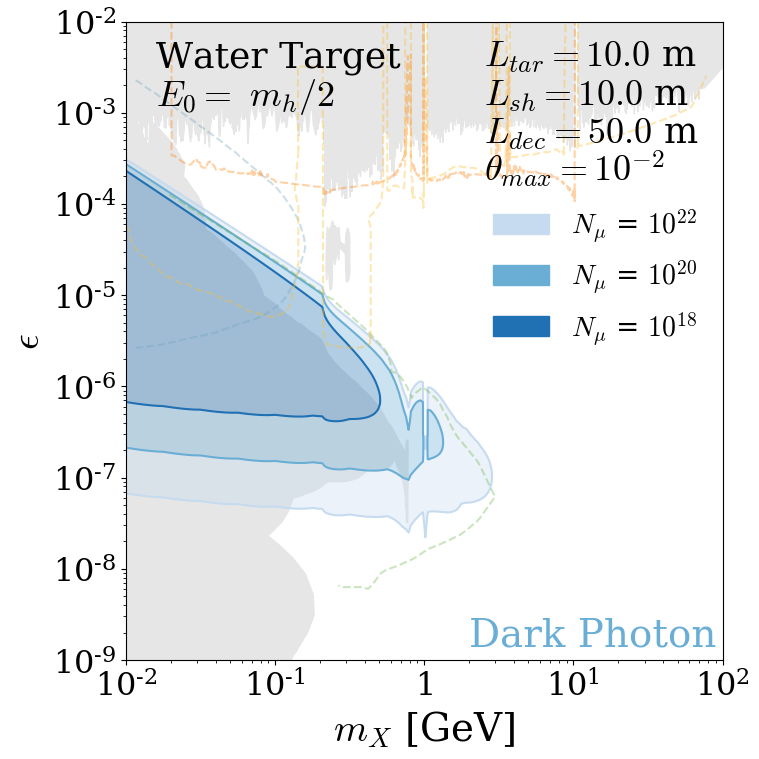

Checking for existing event yield data at experiments/Water/experiment_darkX_e1500_t10_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 100m, at 1500 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


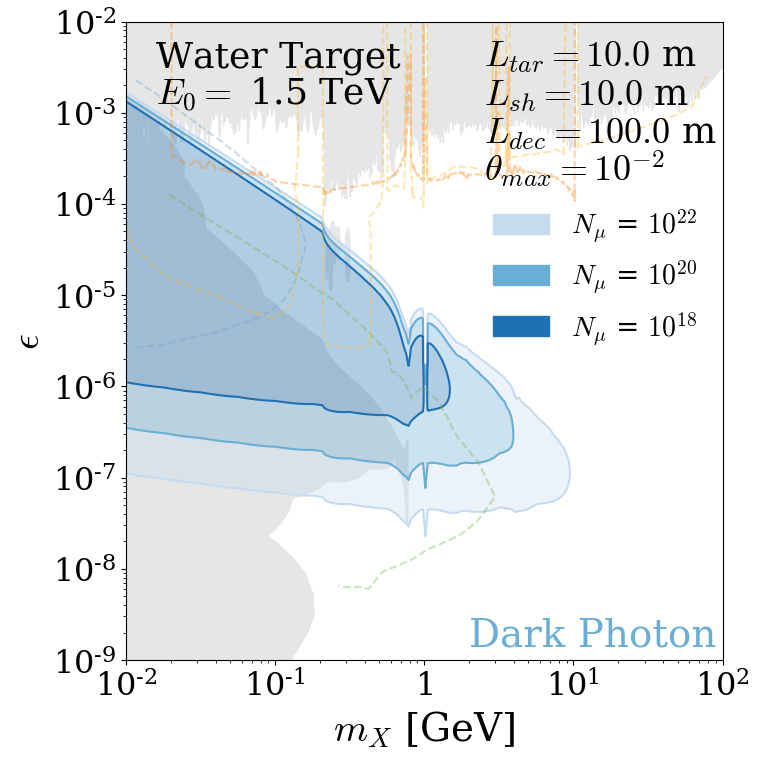

Checking for existing event yield data at experiments/Water/experiment_darkX_e5000_t10_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 100m, at 5000 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


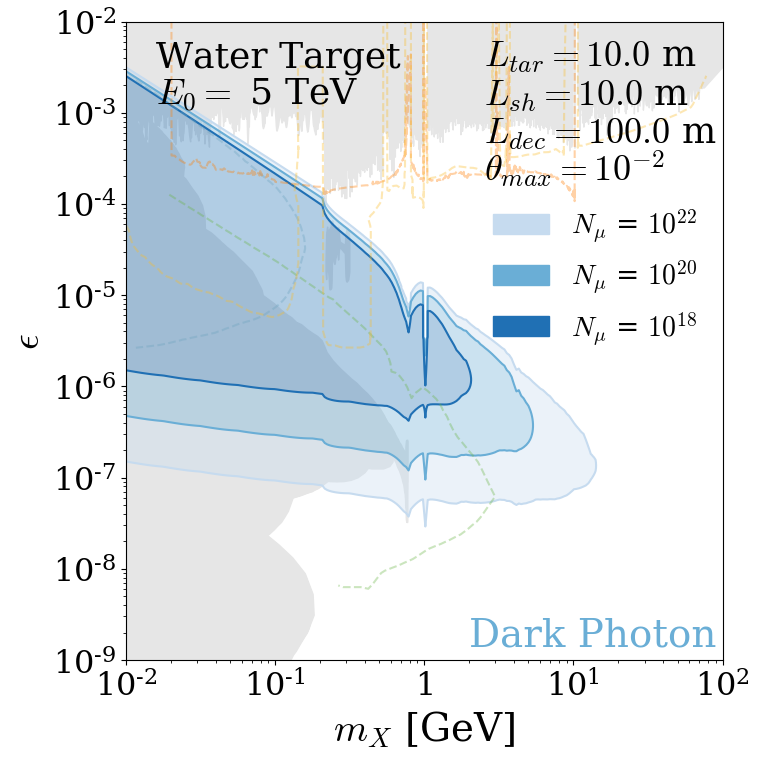

Checking for existing event yield data at experiments/Lead/experiment_darkX_e10_t0.5_s5_d10/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 0m, 5m, 10m, at 10 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


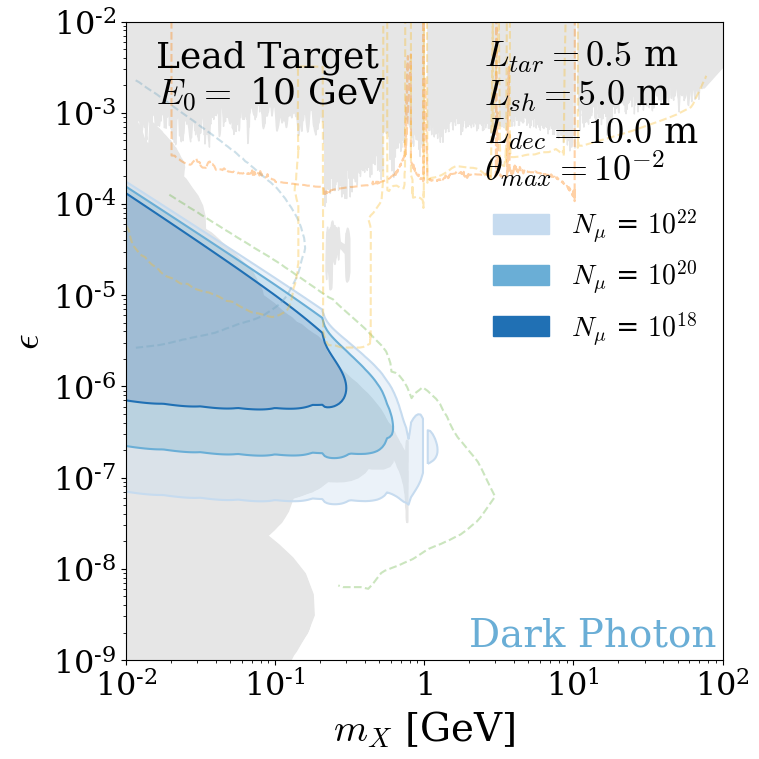

Checking for existing event yield data at experiments/Lead/experiment_darkX_e63_t2_s10_d50/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 2m, 10m, 50m, at 63 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


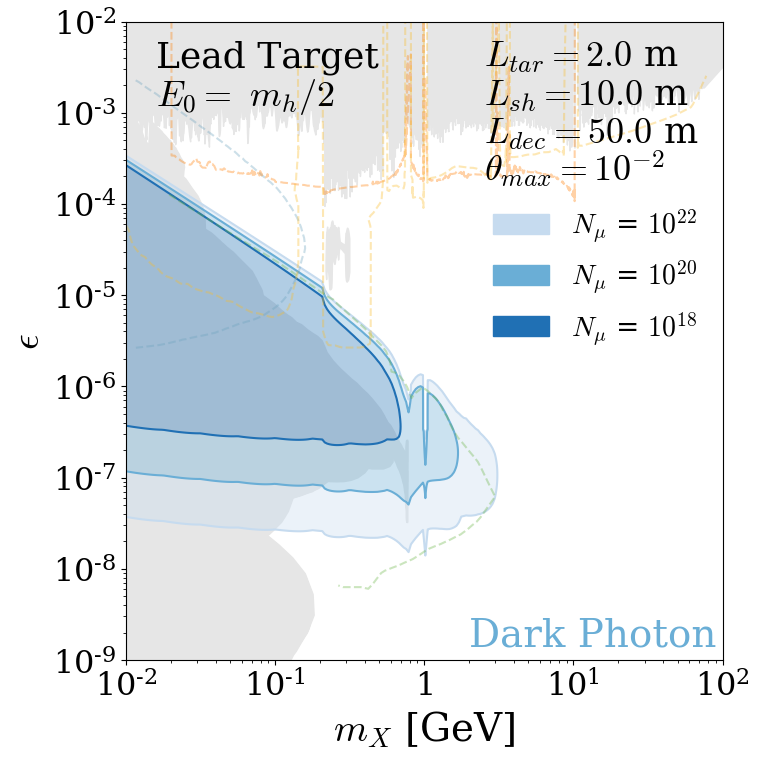

Checking for existing event yield data at experiments/Lead/experiment_darkX_e1500_t5_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 5m, 10m, 100m, at 1500 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


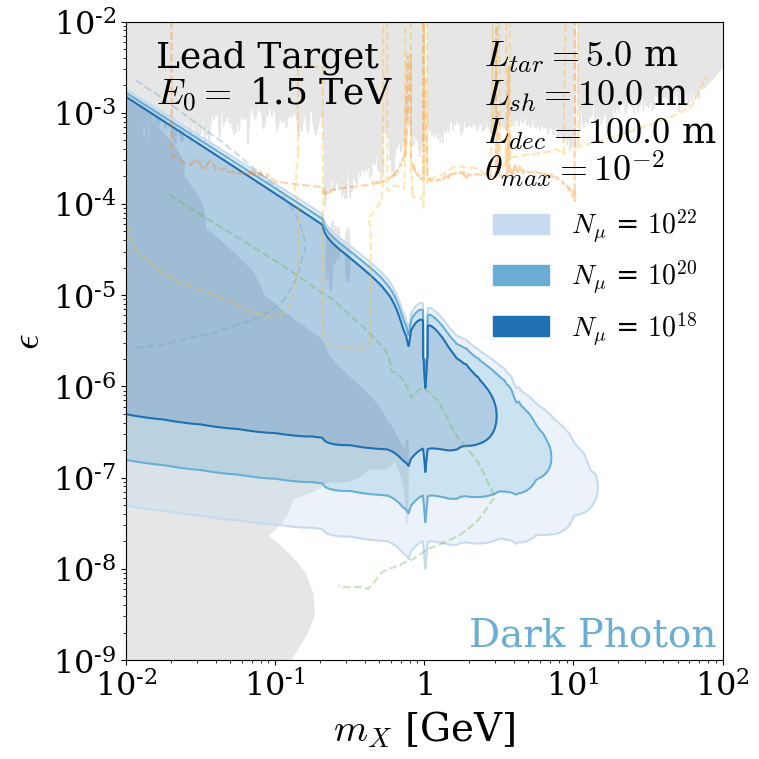

Checking for existing event yield data at experiments/Lead/experiment_darkX_e5000_t5_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 5m, 10m, 100m, at 5000 GeV are available!

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]


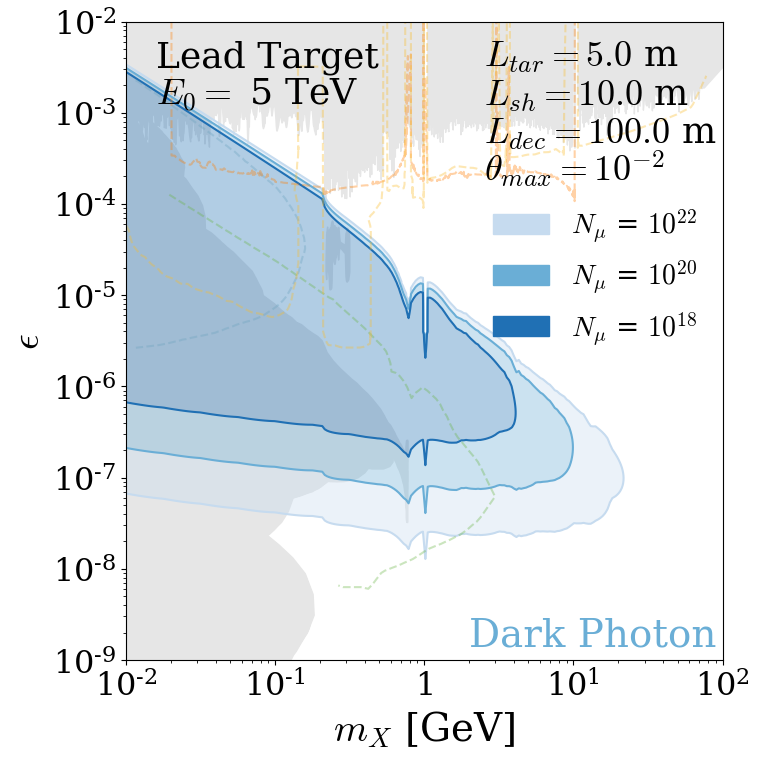

In [7]:
# ########## Leptophilic model parameters ##########
plot_mrange = (-2, 2)
plot_erange = (-9, -2)
epsilon_vs_g = True

cases = ["Vector"]

# Decay Parameters
model_names = {"Vector" : r"Dark Photon",}
model_name_string = "darkX"
decay_dictionary = { # Format is [weight, mass, visibility]
                    "electrons" : [1, 0.000511, 1],
                    "muons" : [1, 0.105, 1],
                    "taus" : [1, 1.776, 1],
                    "neutrinos" : [0, 0, 0],
                    "hadrons" : [1, 0.105, 1], # Weight gets multiplied by Rpp
                    }





# ##### Load data #####


dark_photon_digitized_dir = "OtherSearchesDigitized/digitized-bounds/dark-photon/"


# New searches (2020+?)
faser3_bottom = read_digitized(dark_photon_digitized_dir + "new/newFaserBottom.csv", MeV_to_GeV, None, firstrow=00)
faser3_top = read_digitized(dark_photon_digitized_dir + "new/newFaserTop.csv", MeV_to_GeV, None, firstrow=00)
excludedFull = read_digitized(dark_photon_digitized_dir + "new/excludedFull.csv", pow10, pow10, firstrow=00)

new_searches = []


# Resonance Searches
na48_data = read_digitized(dark_photon_digitized_dir + "na48-dark-photon-bounds.csv", MeV_to_GeV, np.sqrt, firstrow=10)
babar_data = read_digitized(dark_photon_digitized_dir + "babar2014PlotG.txt", pow10, pow10, firstrow=00)
mainz_data = read_digitized(dark_photon_digitized_dir + "Mainz2014PlotG.txt", pow10, pow10, firstrow=00)
apex_data = read_digitized(dark_photon_digitized_dir + "apex2011plotG.txt", pow10, pow10, firstrow=00)
cms2019_data = read_digitized(dark_photon_digitized_dir + "cms2019-dark-photon-bounds.csv", None, np.sqrt, firstrow=5, lastrow=205)
kloe2016_data = read_digitized(dark_photon_digitized_dir + "kloe2016-dark-photon-bounds.csv", MeV_to_GeV, np.sqrt, firstrow=00)
lhcb_data = read_digitized(dark_photon_digitized_dir + "lhcb2019-prompt-dark-photon-bounds.txt", None, np.sqrt, firstrow=00)

resonances = [na48_data, babar_data, mainz_data, apex_data, cms2019_data, kloe2016_data, lhcb_data]

# Beam Dump Searches
sn1987a_data = read_digitized(dark_photon_digitized_dir + "sn1987-dark-photon-bounds.csv", MeV_to_GeV, None, firstrow=00)
e774_data = read_digitized(dark_photon_digitized_dir + "e774-dark-photon-bounds.csv", None, None, firstrow=00)
e141_data = read_digitized(dark_photon_digitized_dir + "e141-dark-photon-bounds.csv", None, None, firstrow=00)
e137old_data = read_digitized(dark_photon_digitized_dir + "e137-dark-photon-bounds.csv", None, None, firstrow=00)
e137_data = read_digitized(dark_photon_digitized_dir + "e137-updated-dark-photon-bounds.csv", MeV_to_GeV, None, firstrow=00)
charm_data = read_digitized(dark_photon_digitized_dir + "charm-dark-photon-bounds.csv", MeV_to_GeV, None, firstrow=00)
nucal_data = read_digitized(dark_photon_digitized_dir + "nucal-dark-photon-bounds.csv", None, None, firstrow=00)
u70_data = read_digitized(dark_photon_digitized_dir + "u70-dark-photon-bounds.csv", None, None, firstrow=00)

beam_dumps = [sn1987a_data, e774_data, e141_data, e137old_data, e137_data, charm_data, nucal_data, u70_data]

# Future Searches
ship_data = read_digitized(dark_photon_digitized_dir + "ship-dark-photon-bounds.csv", MeV_to_GeV, None, firstrow=00)
awake50_data = read_digitized(dark_photon_digitized_dir + "awake50-dark-photon-bounds.csv", None, None, firstrow=00)
# awake100_data = read_digitized(dark_photon_digitized_dir + "awake100-dark-photon-bounds.csv", None, None, firstrow=00)
belle2_data = read_digitized(dark_photon_digitized_dir + "belle2-dark-photon-bounds.csv", None, None, firstrow=00)
lhcbproj_data_1 = read_digitized(dark_photon_digitized_dir + "lhcb-projected-dark-photon-bounds-1.csv", None, np.sqrt, firstrow=00)
lhcbproj_data_2 = read_digitized(dark_photon_digitized_dir + "lhcb-projected-dark-photon-bounds-2.csv", None, np.sqrt, firstrow=00)
lhcbproj_data_3 = read_digitized(dark_photon_digitized_dir + "lhcb-projected-dark-photon-bounds-3.csv", None, np.sqrt, firstrow=00)
lhcbproj_data = np.concatenate([ lhcbproj_data_1, lhcbproj_data_2])
# lhcbproj_data = lhcbproj_data[lhcbproj_data[:,0].argsort()]

future_projections = [ship_data, awake50_data, belle2_data, lhcbproj_data]
future_projections_colors = ["#6ab547", "#6ea4bf", "#ff7d00", "#fabc2a"]
future_projections_strings = ["SHiP", "AWAKE 50", "LHCb (500 fb$^{-1}$)", "Belle-II"]

# Other (LHCb LLP)
lhcbllp_data_low = read_digitized(dark_photon_digitized_dir + "lhcb2019-long-lived-dark-photon-bounds.txt", MeV_to_GeV, np.sqrt, firstrow=00, usecols=[0,1])
lhcbllp_data_high = read_digitized(dark_photon_digitized_dir + "lhcb2019-long-lived-dark-photon-bounds.txt", MeV_to_GeV, np.sqrt, firstrow=00, usecols=[0,2])


# #################################################
# ##### Don't touch below #########################

# Build configs
if run_dark_photon:
    for target in targets:
        for E in E_0s:

            target_name = target
            target_Z = Zs[target]                # Target nucleus's electric charge
            target_A = As[target]             # Target atomic mass [g/mol] ~ [GeV]
            target_density = rhos[target]           # Target material density [g/cm3]
            target_length = l_T[target][E]          # Length of target [m]

            cross_section_dir = f"experiments/{target_name}/cross_sections/"
            experiment_dir = f"experiments/{target_name}/experiment_{model_name_string}_e{E}_t{target_length}_s{shield_lengths[E]}_d{detector_lengths[E]}/"

            config = build_full_config(E < 100, xbins, cases, m_Xs, cross_section_dir, experiment_dir, E, m_lepton, theta_max, target_name, target_Z, target_A, target_density, target_length, shield_lengths[E], detector_lengths[E],  model_name_string, decay_dictionary, N_mu, plot_mrange, plot_erange)        
            calculate_event_yields(config, force_rerun = force_rerun)


            # # Plot (Once with dashed lines, once without to coverup scars)
            fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))
            for resonance in resonances:
                plot_grey(ax, config, resonance)

            for beam_dump in beam_dumps:
                plot_grey(ax, config, beam_dump)

            for i in range(len(future_projections)):
                plot_projection(ax, config, future_projections[i], future_projections_colors[i], future_projections_strings[i])
    
            ax.fill_between(lhcbllp_data_low[:,0], lhcbllp_data_low[:,1], lhcbllp_data_high[:,1], color = (0.9, 0.9, 0.9), zorder = 1)

            plot_fill_between(ax, config, faser3_bottom, faser3_top)
            plot_grey(ax, config, excludedFull, dashed = False)

            exclusion_plot(config, "Vector", model_names["Vector"], [np.log10(5e-2), np.log10(5), np.log10(5e2)], "Blues",
                            labels = [r"$ 10^{22}$", r"$ 10^{20}$", r"$ 10^{18}$"], epsilon_vs_g = epsilon_vs_g,
                            newfig = False)
        

Leptophilic Scalar

Checking for existing event yield data at experiments/Water/experiment_leptophilic_e10_t4_s5_d10/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 4m, 5m, 10m, at 10 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


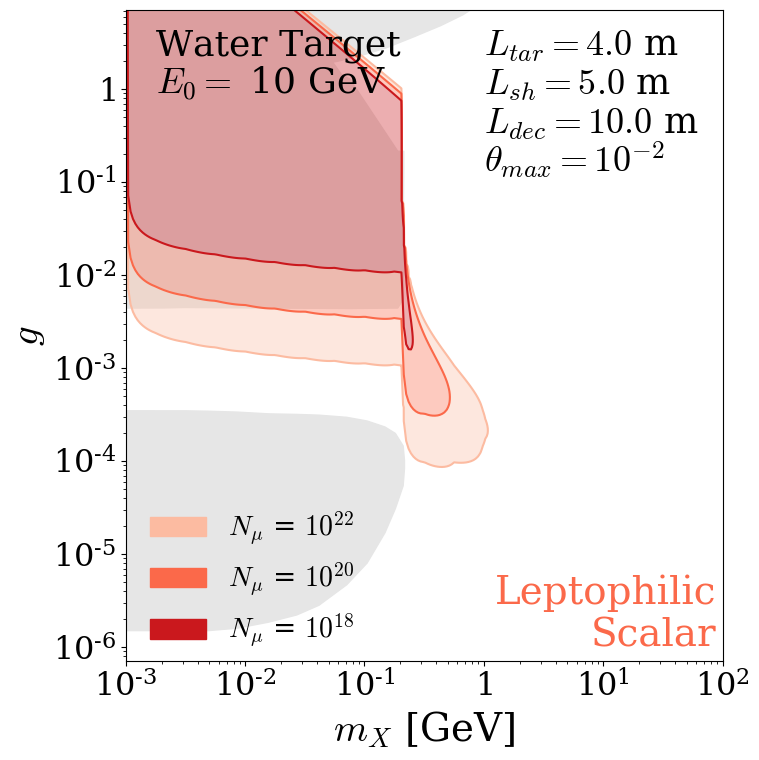

Checking for existing event yield data at experiments/Water/experiment_leptophilic_e63_t10_s10_d50/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 50m, at 63 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


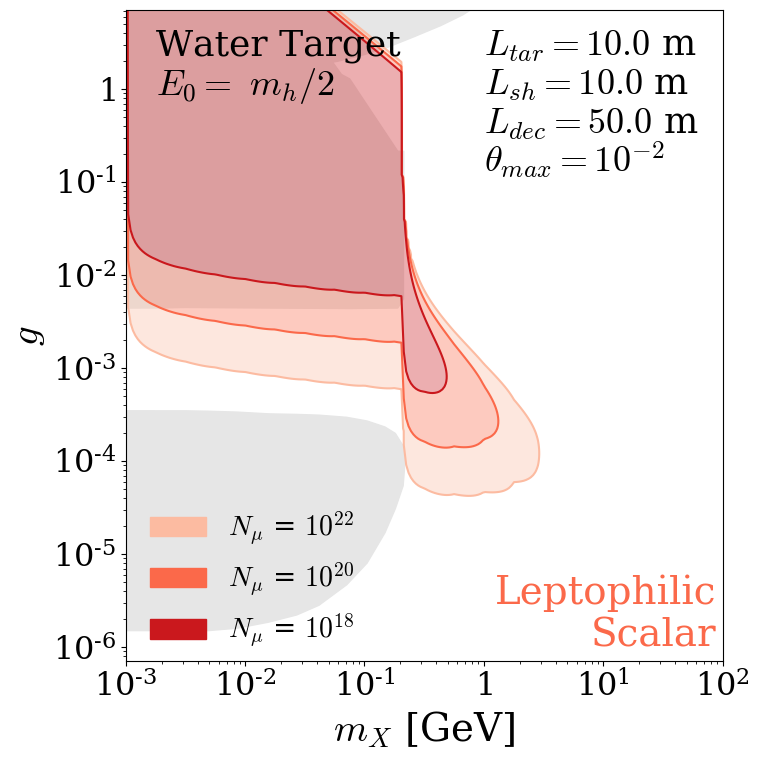

Checking for existing event yield data at experiments/Water/experiment_leptophilic_e1500_t10_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 100m, at 1500 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


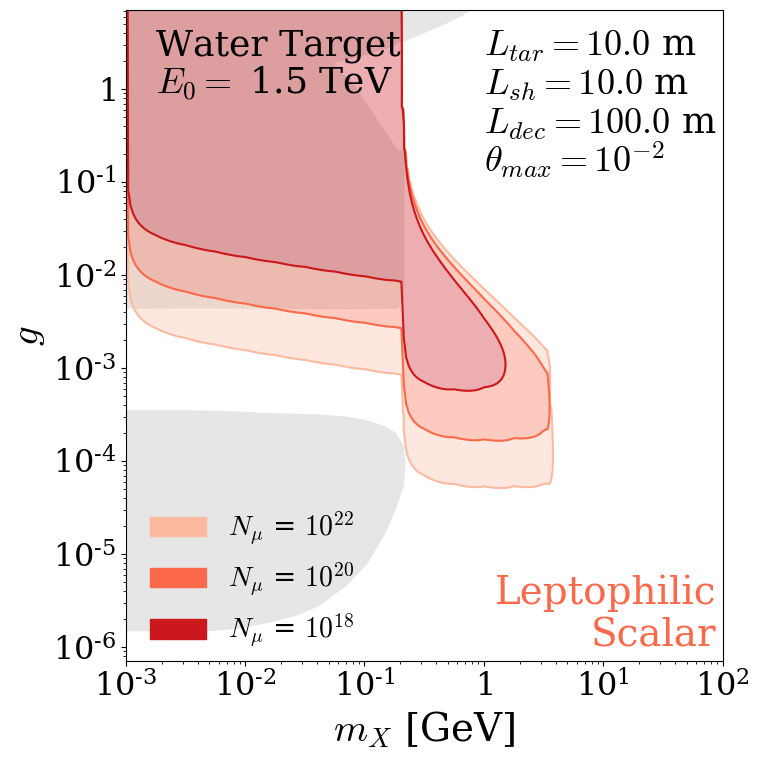

Checking for existing event yield data at experiments/Water/experiment_leptophilic_e5000_t10_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 100m, at 5000 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


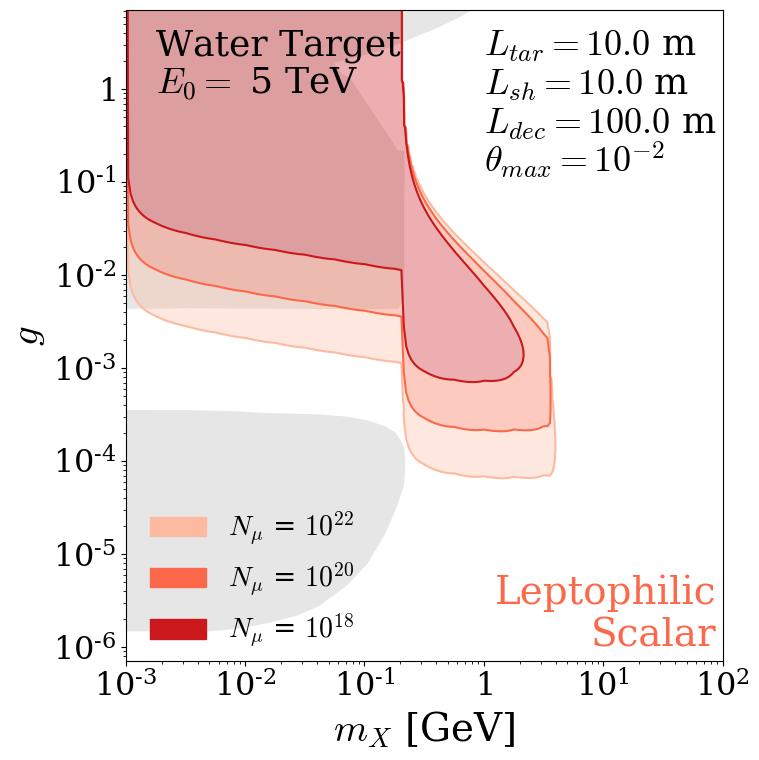

Checking for existing event yield data at experiments/Lead/experiment_leptophilic_e10_t0.5_s5_d10/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 0m, 5m, 10m, at 10 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


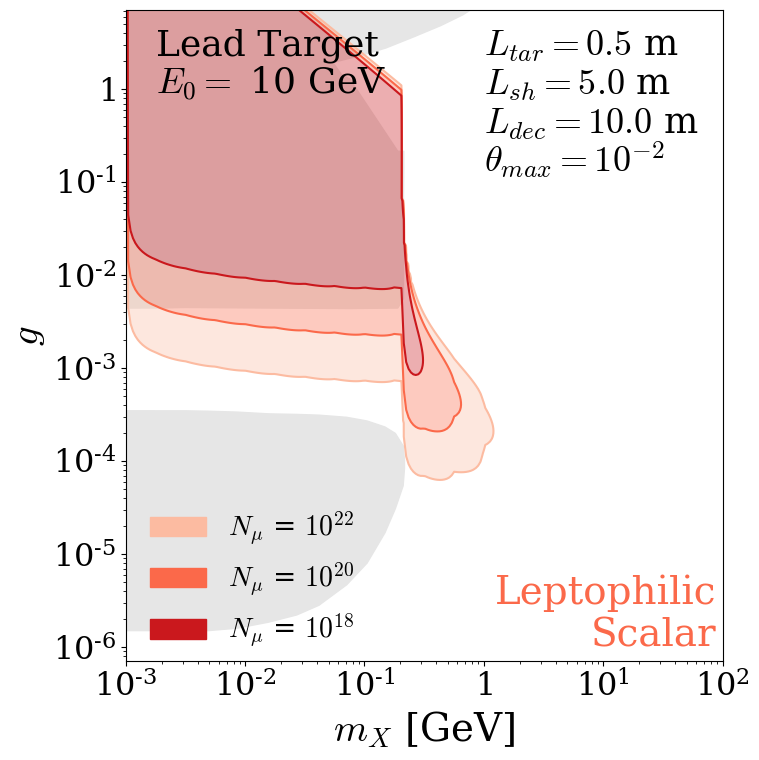

Checking for existing event yield data at experiments/Lead/experiment_leptophilic_e63_t2_s10_d50/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 2m, 10m, 50m, at 63 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


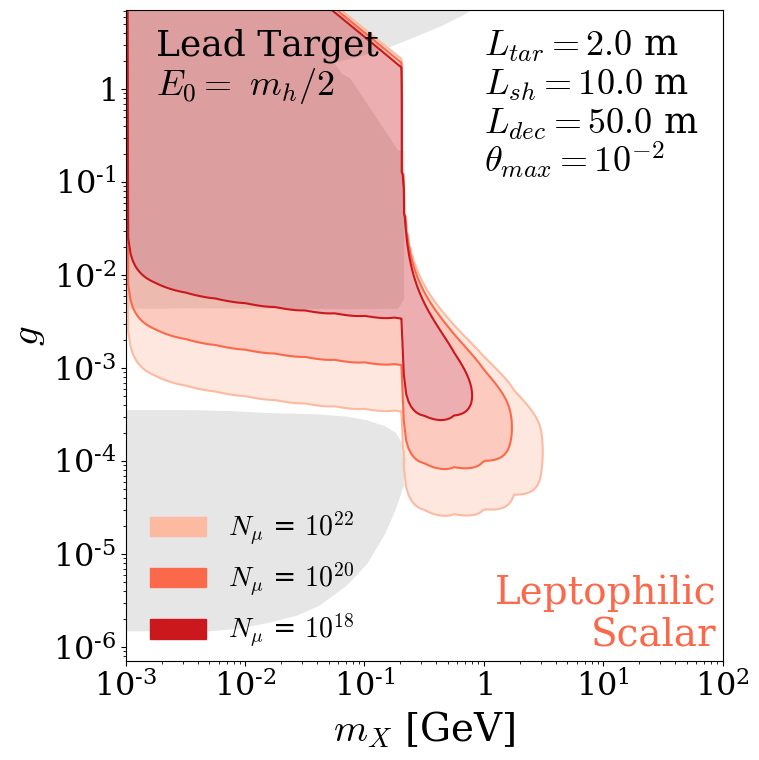

Checking for existing event yield data at experiments/Lead/experiment_leptophilic_e1500_t5_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 5m, 10m, 100m, at 1500 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


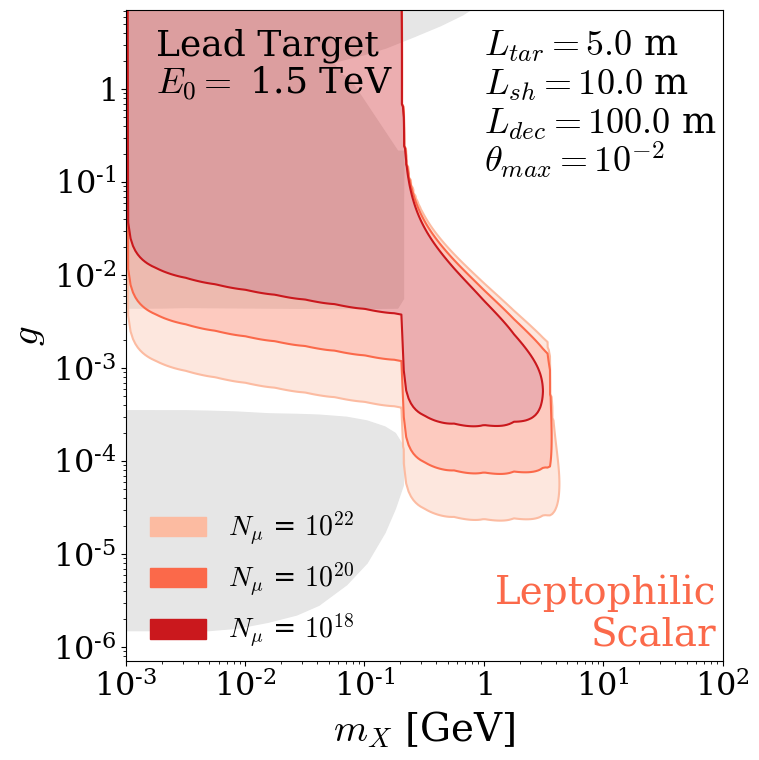

Checking for existing event yield data at experiments/Lead/experiment_leptophilic_e5000_t5_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 5m, 10m, 100m, at 5000 GeV are available!

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.7925720876585928, 0.09328719723183392, 0.11298731257208766, 1.0)]


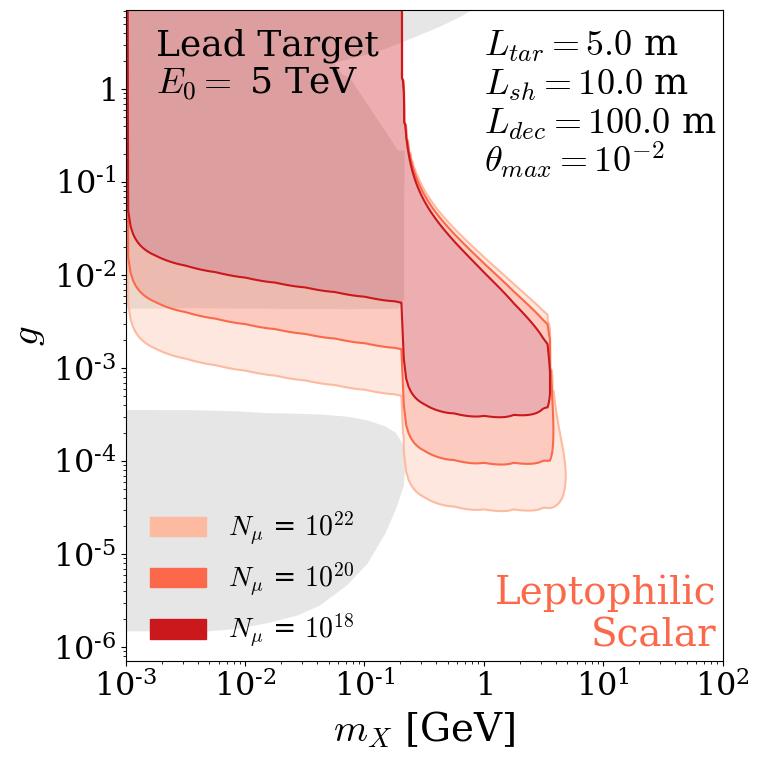

In [8]:
# ########## Leptophilic model parameters ##########
plot_mrange = (-3, 2)
plot_erange = (-9, -2)
epsilon_vs_g = False

cases = ["Scalar"]

# Decay Parameters
model_names = {"Scalar" : r"Leptophilic Scalar",}
model_name_string = "leptophilic"

m_e = 0.000511 # GeV
m_mu = 0.105 # GeV
m_tau = 1.776 # GeV

vev = 246 # GeV

decay_dictionary = { # Format is [weight, mass, visibility]
                    "electrons" : [(m_e / m_mu)**2, m_e, 1],
                    "muons" : [1.0, m_mu, 1],
                    "taus" : [(m_tau / m_mu)**2, m_tau, 0],
                    "neutrinos" : [3 * 0.0 / 0.105, 0, 0],
                    "hadrons" : [0, m_mu, 1], # Weight gets multiplied by Rpp
                    }


# Conversion factor
def gmu_to_epsilon(gmu):

    higgs_yukawa = 0.105 / vev
    return gmu / higgs_yukawa

# Conversion factor
def F_to_g(F):
    return vev / F

# Beam Dump Searches
yukawa_digitized_dir = "OtherSearchesDigitized/digitized-bounds/yukawa/"

e137_data_lower = read_digitized(yukawa_digitized_dir + "e137-limits-lower.csv", None, gmu_to_epsilon, firstrow=1)
e137_data_upper = read_digitized(yukawa_digitized_dir + "e137-limits-upper.csv", None, gmu_to_epsilon, firstrow=1)
orsay_data_lower = read_digitized(yukawa_digitized_dir + "orsay-limits-lower.csv", None, gmu_to_epsilon, firstrow=1)
orsay_data_upper = read_digitized(yukawa_digitized_dir + "orsay-limits-upper.csv", None, gmu_to_epsilon, firstrow=1)


blob2_upper = read_digitized(yukawa_digitized_dir + "blob2_a.csv", None, F_to_g, firstrow=0)
blob2_lower = read_digitized(yukawa_digitized_dir + "blob2_b.csv", None, F_to_g, firstrow=0)


gminus2_data = read_digitized(yukawa_digitized_dir + "gminus2-limits.csv", None, gmu_to_epsilon, firstrow=1)
searches = [gminus2_data]


# #################################################
# ##### Don't touch below #########################

# Build configs
if run_leptophilic:
    for target in targets:
        for E in E_0s:

            target_name = target
            target_Z = Zs[target]                # Target nucleus's electric charge
            target_A = As[target]             # Target atomic mass [g/mol] ~ [GeV]
            target_density = rhos[target]           # Target material density [g/cm3]
            target_length = l_T[target][E]          # Length of target [m]

            cross_section_dir = f"experiments/{target_name}/cross_sections/"
            experiment_dir = f"experiments/{target_name}/experiment_{model_name_string}_e{E}_t{target_length}_s{shield_lengths[E]}_d{detector_lengths[E]}/"

            config = build_full_config(E < 100, xbins, cases, m_Xs, cross_section_dir, experiment_dir, E, m_lepton, theta_max, target_name, target_Z, target_A, target_density, target_length, shield_lengths[E], detector_lengths[E],  model_name_string, decay_dictionary, N_mu, plot_mrange, plot_erange)        
            calculate_event_yields(config, force_rerun = force_rerun)


            fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))

            for search in searches:
                plot_grey(ax, config, search)


            ax.fill_between(e137_data_lower[:,0], e137_data_lower[:,1], np.interp(e137_data_lower[:,0], e137_data_upper[:,0], e137_data_upper[:,1]), color = (0.9, 0.9, 0.9), zorder = 1)
            ax.fill_between(orsay_data_lower[:,0], orsay_data_lower[:,1], np.interp(orsay_data_lower[:,0], orsay_data_upper[:,0], orsay_data_upper[:,1]), color = (0.9, 0.9, 0.9), zorder = 1)

            plot_fill_between(ax, config, blob2_lower, blob2_upper)


            
            exclusion_plot(config, "Scalar", model_names["Scalar"], [np.log10(5e-2), np.log10(5), np.log10(5e2)], "Reds",
                            scale_factor= 1.0/(m_mu / vev),
                            labels = [r"$ 10^{22}$", r"$ 10^{20}$", r"$ 10^{18}$"], epsilon_vs_g = epsilon_vs_g,
                            y_string="$g$",
                            newfig=False,
                            bounding_box=(0.425,0.125))
            
        

# Leptophilic Pseudoscalar

Checking for existing event yield data at experiments/Water/experiment_leptophilic_ps_e10_t4_s5_d10/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 4m, 5m, 10m, at 10 GeV are available!

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


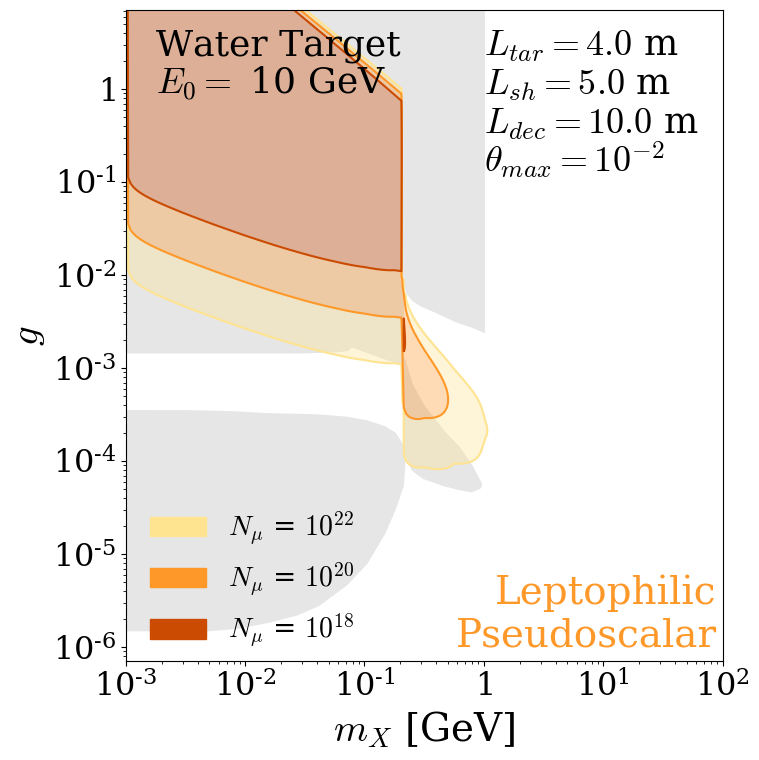

Checking for existing event yield data at experiments/Water/experiment_leptophilic_ps_e63_t10_s10_d50/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 50m, at 63 GeV are available!

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


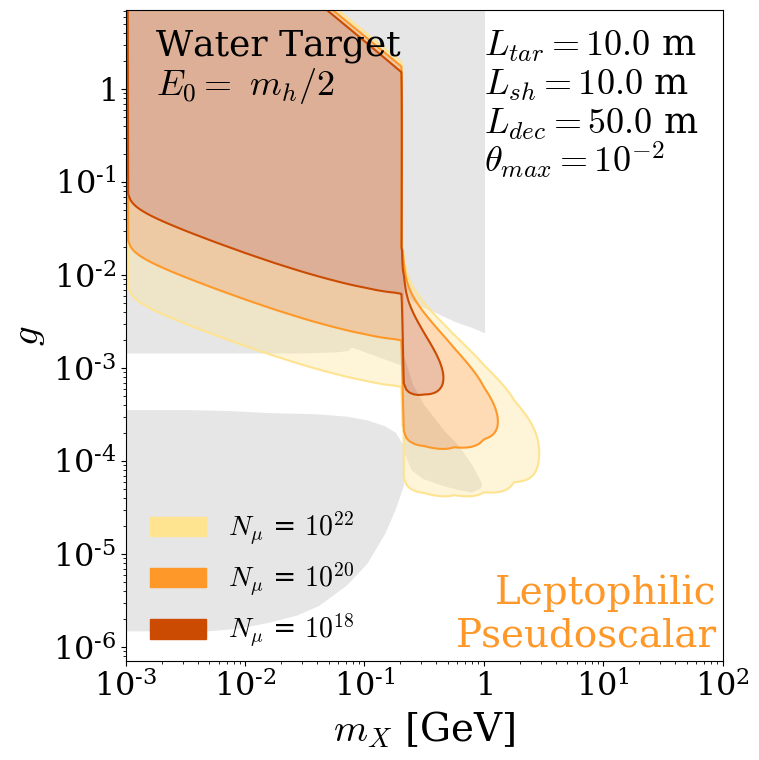

Checking for existing event yield data at experiments/Water/experiment_leptophilic_ps_e1500_t10_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 100m, at 1500 GeV are available!

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


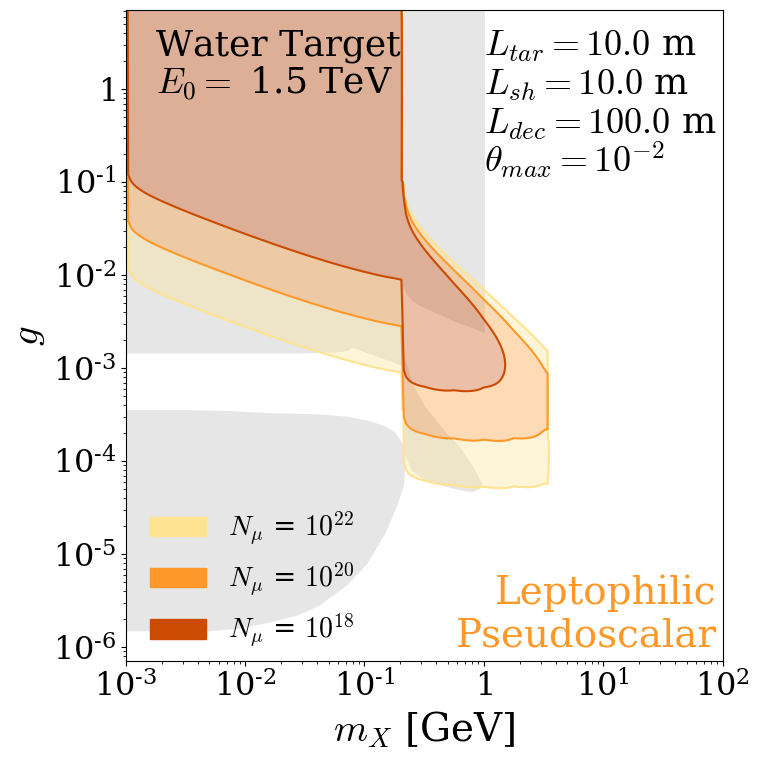

Checking for existing event yield data at experiments/Water/experiment_leptophilic_ps_e5000_t10_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 100m, at 5000 GeV are available!

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


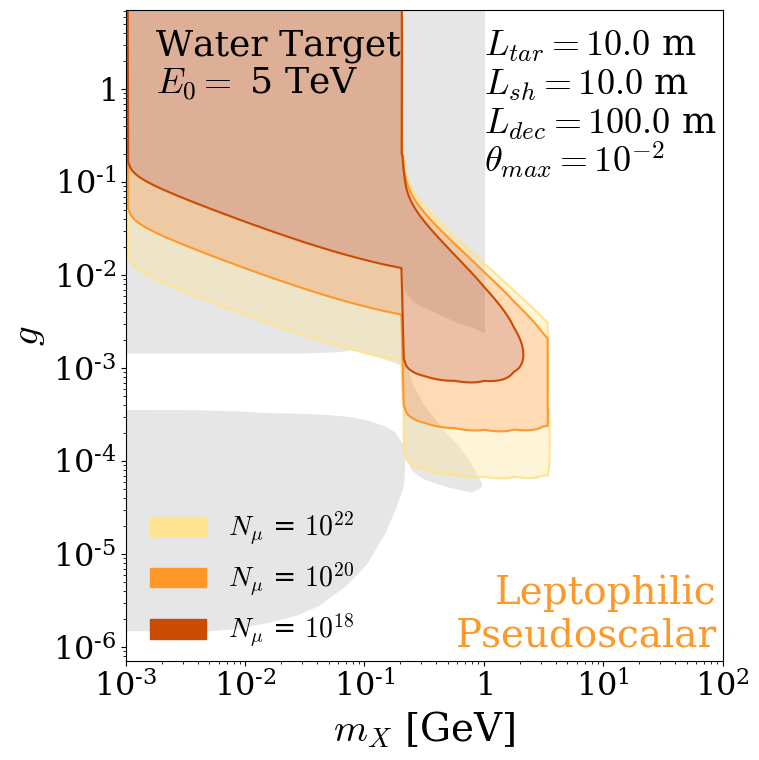

Checking for existing event yield data at experiments/Lead/experiment_leptophilic_ps_e10_t0.5_s5_d10/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 0m, 5m, 10m, at 10 GeV are available!

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


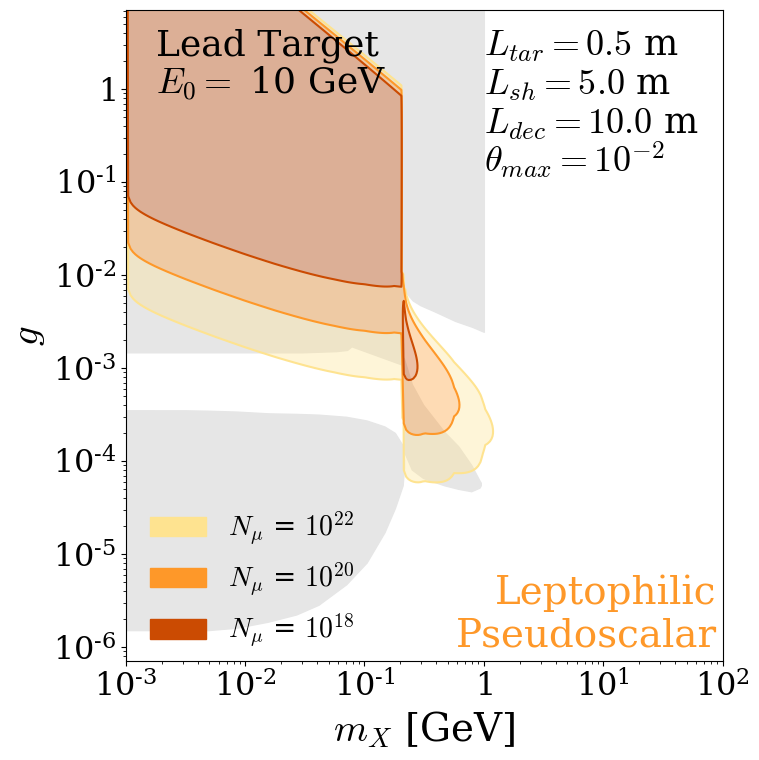

Checking for existing event yield data at experiments/Lead/experiment_leptophilic_ps_e63_t2_s10_d50/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 2m, 10m, 50m, at 63 GeV are available!

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


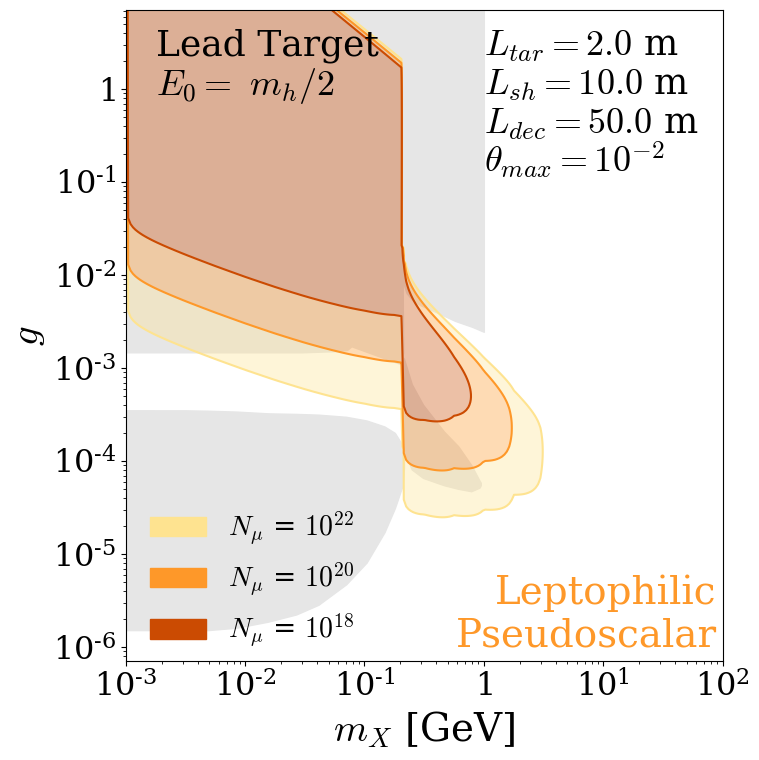

Checking for existing event yield data at experiments/Lead/experiment_leptophilic_ps_e1500_t5_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 5m, 10m, 100m, at 1500 GeV are available!

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


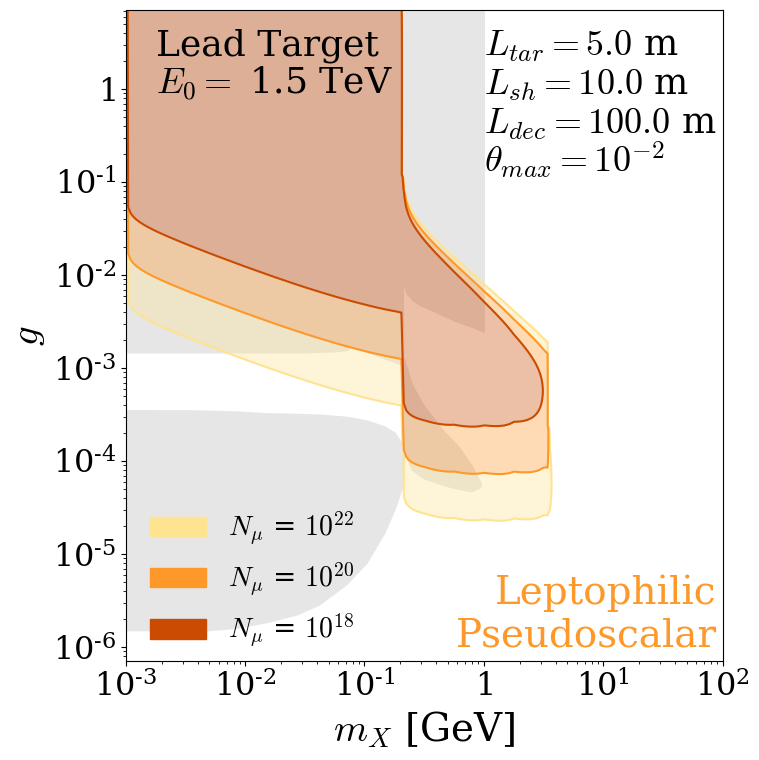

Checking for existing event yield data at experiments/Lead/experiment_leptophilic_ps_e5000_t5_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Lead with target, shield, detector lengths of 5m, 10m, 100m, at 5000 GeV are available!

[(0.996078431372549, 0.8892425990003844, 0.5665974625144176, 1.0), (0.9949711649365629, 0.5974778931180315, 0.15949250288350636, 1.0), (0.7952941176470588, 0.2958246828143022, 0.008027681660899655, 1.0)]


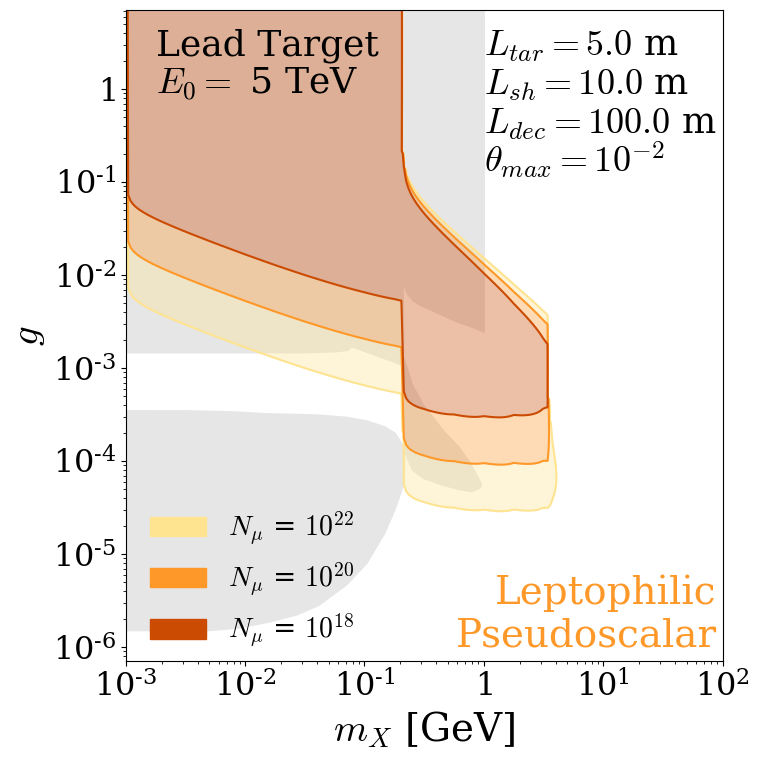

In [9]:
# ########## Leptophilic model parameters ##########
plot_mrange = (-3, 2)
plot_erange = (-9, -2)
epsilon_vs_g = False

cases = ["Pseudoscalar"]

# Decay Parameters
model_names = {"Pseudoscalar" : r"Leptophilic Pseudoscalar",}
model_name_string = "leptophilic_ps"

m_e = 0.000511 # GeV
m_mu = 0.105 # GeV
m_tau = 1.776 # GeV

vev = 246 # GeV

decay_dictionary = { # Format is [weight, mass, visibility]
                    "electrons" : [(m_e / m_mu)**2, m_e, 1],
                    "muons" : [1.0, m_mu, 1],
                    "taus" : [(m_tau / m_mu)**2, m_tau, 0],
                    "neutrinos" : [3 * 0.0 / 0.105, 0, 0],
                    "hadrons" : [0, m_mu, 1], # Weight gets multiplied by Rpp
                    }

# Conversion factor
def F_to_g(F):
    return vev / F

# Beam Dump Searches
ps_digitized_dir = "OtherSearchesDigitized/digitized-bounds/leptophilic_ps/"

blob1 = read_digitized(ps_digitized_dir + "blob1.csv", None, F_to_g, firstrow=0)
blob2_lower = read_digitized(ps_digitized_dir + "blob2_b.csv", None, F_to_g, firstrow=0)
blob2_upper = read_digitized(ps_digitized_dir + "blob2_a.csv", None, F_to_g, firstrow=0)
blob3_lower = read_digitized(ps_digitized_dir + "blob3_b.csv", None, F_to_g, firstrow=0)
blob3_upper = read_digitized(ps_digitized_dir + "blob3_a.csv", None, F_to_g, firstrow=0)




# #################################################
# ##### Don't touch below #########################

# Build configs
if run_leptophilic_ps:
    for target in targets:
        for E in E_0s:

            target_name = target
            target_Z = Zs[target]                # Target nucleus's electric charge
            target_A = As[target]             # Target atomic mass [g/mol] ~ [GeV]
            target_density = rhos[target]           # Target material density [g/cm3]
            target_length = l_T[target][E]          # Length of target [m]

            cross_section_dir = f"experiments/{target_name}/cross_sections/"
            experiment_dir = f"experiments/{target_name}/experiment_{model_name_string}_e{E}_t{target_length}_s{shield_lengths[E]}_d{detector_lengths[E]}/"

            config = build_full_config(E < 100, xbins, cases, m_Xs, cross_section_dir, experiment_dir, E, m_lepton, theta_max, target_name, target_Z, target_A, target_density, target_length, shield_lengths[E], detector_lengths[E],  model_name_string, decay_dictionary, N_mu, plot_mrange, plot_erange)        
            calculate_event_yields(config, force_rerun = force_rerun)


            fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))
            plot_grey(ax, config, blob1)
            plot_fill_between(ax, config, blob2_lower, blob2_upper)
            plot_fill_between(ax, config, blob3_lower, blob3_upper)

        

            
            exclusion_plot(config, "Pseudoscalar", model_names["Pseudoscalar"], [np.log10(5e-2), np.log10(5), np.log10(5e2)], "YlOrBr",
                            scale_factor= 1.0/(0.105 / vev),
                            labels = [r"$ 10^{22}$", r"$ 10^{20}$", r"$ 10^{18}$"], epsilon_vs_g = epsilon_vs_g,
                            y_string="$g$",
                            newfig=False,
                            bounding_box=(0.425,0.125))
            
        